# Разработка моделей машинного обучения для прогнозирования и повышения покупательской активности постоянных клиентов интернет-магазина

**Краткое описание задачи:**

Выполнить прогноз покупательской активности постоянных клиентов интернет-магазина и предложить способ увеличения их покупательской активности (одного или нескольких сегментов клиентов).

**План работы:**
1. Изучить входные данные, оценить полноту и качество входных данных для достижения цели исследования. Определить задачи предобработки данных.
2. Осуществить предобработку данных в части улучшение качества данных для дальнейшего анализа.
3. Провести исследовательский анализ данных, а также оценить (уточнить) необходимость формирования дополнительных категорий, параметров и групп данных для достижения цели исследования, дополнить ими входные данные.
4. Объединить необходимые данные в единый дата-сет.
5. Провести корреляционный анализ данных для оценки взаимосвязи между целевыми и входными признаками.
6. Разработать модели машинного обучения. Проанализировать качество разработанных моделей машинного обучения. Выбрать лучшую модель МО.
6. Оценить важность признаков (данных), представленных подразделениями организации.
7. Выполнить сегментацию пользователей и разработать для них персонализированные предложения.

## Импорт и обновление библиотек, создание функций

In [1]:
# Загружаем библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
    confusion_matrix, accuracy_score, recall_score, precision_score, \
    roc_auc_score, roc_curve, f1_score, fbeta_score, make_scorer
from sklearn.inspection import permutation_importance
from itertools import combinations

In [3]:
# Create constants
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Cоздание функций

Создадим функции, используемые в работе

In [4]:
# Функция, выводящая красивый график (подписанный, с нормальным количеством корзин и гридом)
# для численных столбцов (int, float, long) дата-сетов
def overview_plot(df):
    num_col_names = df.select_dtypes(include='number').columns.tolist()
    
    for col in num_col_names:
        df[col].plot(kind='hist', bins=30, grid=True, legend=False)
        legend = '[' + col + ']'
        plt.title('Распределение исследуемого параметра.\nСтолбец ' + legend)
        plt.xlabel('Единицы изменения\nисследуемого параметра')
        plt.ylabel('Частота повторений\nисследуемого параметра')
        plt.show()
    
    if len(num_col_names) == 0: print('В дата-сете нет численных столбцов')

In [5]:
# Функция, выводящая красивый график (подписанный, с нормальным количеством корзин и гридом)
# для численных столбцов (int, float, long) дата-сетов
def overview_plot_new(df):
    num_col_names = df.select_dtypes(include='number').columns.tolist()
    for col in num_col_names:
        bins_2 = int(np.round(math.sqrt(len(df[col])), 0))
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        df[col].plot(kind='hist', bins=bins_2, grid=True, legend=False, ax=axes[0])
        legend = '[' + col + ']'
        plt.title('Распределение исследуемого параметра.\nСтолбец ' + legend)
        plt.xlabel('Единицы изменения\nисследуемого параметра')
        plt.ylabel('Частота повторений\nисследуемого параметра')
        
        df[col].plot(kind='box', grid=True, legend=False, ax=axes[1])
        plt.title('Диаграмма размаха\nисследуемого параметра.\nСтолбец ' + legend)
        plt.xlabel('Наименование\nисследуемого столбца')
        plt.ylabel('Единицы изменения\nисследуемого параметра')
        fig.tight_layout()
        plt.show()
    
    if len(num_col_names) == 0: print('В дата-сете нет численных столбцов')

In [6]:
# Функция, изменяющая наименования столбцов
def change_columnnames(df):
    col_names = df.columns.tolist()
    new_cols = {}
    for col in col_names:
        new_cols[col] = col.lower().replace(' ', '_')
    df = df.rename(columns = new_cols)
    return df

In [7]:
# Функция, проверяющая столбцы на наличие неявных дубликатов
def check_duplicates(df, columns):
    num_col_names = df[columns].select_dtypes(include='number').columns.tolist()
    str_col_names = df[columns].select_dtypes(exclude='number').columns.tolist()
    for col in str_col_names:
        print(f'Проверяем столбец [{col}]')
        print('---> Количество уникальных значений: {}'.format(df[col].nunique()))
        print('---> Количество уникальных значений после приведения к нижнему регистр: {}'.format(df[col].str.lower().nunique()))
        print('---> Уникальные значения:', df[col].unique())
        print('%%%')
    for col in num_col_names:
        print(f'Проверяем столбец [{col}]')
        print('---> Количество уникальных значений: {}'.format(df[col].nunique()))
        print('---> Общее количество записей: {}'.format(len(df[col])))
        print('%%%')

In [8]:
def check_duplicates(df, columns):
    """
    Функция, проверяющая столбцы на наличие неявных дубликатов
    
    :param df: Дата-сет, в котором ищем дубликаты.
    :param columns: Список солбцов дата-сета df, по которым ищем дубликаты.
    :return: None # Процесс поиска выводится на экран   
    
    """
    
    num_col_names = df[columns].select_dtypes(include='number').columns.tolist()
    str_col_names = df[columns].select_dtypes(exclude='number').columns.tolist()
    
    for col in str_col_names:
        print(f'Проверяем столбец [{col}]')
        print('---> Количество уникальных значений: {}'.format(df[col].nunique()))
        print(
            '---> Количество уникальных значений после приведения к нижнему регистру: {}'
            .format(df[col].str.lower().nunique())
        )
        print('---> Уникальные значения:', df[col].unique())
        print('%%%')
        
    for col in num_col_names:
        print(f'Проверяем столбец [{col}]')
        print('---> Количество уникальных значений: {}'.format(df[col].nunique()))
        print('---> Общее количество записей: {}'.format(len(df[col])))
        print('%%%')

In [9]:
# Функция, выводящая основные показатели для анализа количественных признаков
def my_describe(df, column, desc=['hist', 'QR', 'describe', 'box', 'eject'],
                hist_desc=['Распределение\nисследуемого параметра',
                           'Единицы изменения\nисследуемого параметра',
                           'Частоста повторений\nисследуемого параметра'],
                box_desc=['Диаграмма размаха\nисследуемого параметра',
                           'Наименование\nисследуемого столбца',
                           'Единицы изменения\nисследуемого параметра']):
    
    legend_my_desc = 'Столбец' + ' [' + column + ']'
    
    if 'hist' in desc:
        bins = int(np.round(math.sqrt(len(df[column])), 0))
        df[column].plot(kind='hist', bins=bins, grid=True, legend=True)
        plt.title(hist_desc[0])
        plt.xlabel(hist_desc[1])
        plt.ylabel(hist_desc[2])
        plt.legend([legend_my_desc])
        plt.show()
        
    quartiles = df[column].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    min_diagramm = max(quartiles[0.25] - 1.5*iqr, df[column].min())
    max_diagramm = min(quartiles[0.75] + 1.5*iqr, df[column].max())  
    
    if 'describe' in desc:
        print()
        print('Ключевые характеристики распределения:')
        print(df[column].describe().apply("{0:.2f}".format))

    if 'QR' in desc:
        print()
        print('Ключевые характеристики диграммы размаха:')
        print('IQR\t\t\t{0:.2f}'.format(iqr))
        print('Q1-1,5*IQR\t\t{0:.2f}'.format(quartiles[0.25] - 1.5*iqr))
        print('MIN диаграммы размаха\t{0:.2f}'.format(min_diagramm))
        print('Q3+1,5*IQR\t\t{0:.2f}'.format(quartiles[0.75] + 1.5*iqr))      
        print('MAX диаграммы размаха\t{0:.2f}'.format(max_diagramm))
        print()
        
    if 'box' in desc:
        df[column].plot(kind='box', grid=True, legend=False)
        plt.title(box_desc[0])
        plt.xlabel(box_desc[1])
        plt.ylabel(box_desc[2])
        plt.show()
    
    if 'eject' in desc:
        print('Ключевые характеристики выбросов:')
        print('Количество выбросов (вверх)\t{0:.0f}'
              .format(len(df[df[column] > max_diagramm])))
        print('Доля выбросов (вверх)\t\t{0:.2f}%'
              .format(len(df[df[column] > max_diagramm]) / len(df) * 100))
        print('Количество выбросов (вниз)\t{0:.0f}'
              .format(len(df[df[column] < min_diagramm])))
        print('Доля выбросов (вниз)\t\t{0:.2f}%'
              .format(len(df[df[column] < min_diagramm]) / len(df) * 100))

In [10]:
# Функция, позволяющая оценить нормальность распределения количественной величины
def is_norm(data):
    res = stats.normaltest(data)
    stats.probplot(data, dist='norm', plot=plt)
    plt.show()
    # Коэффициент статистической значимости установим 0.05
    if res.pvalue > 0.05:
        return 'p-value = {}. Имеются основания говорить о нормальности распределения'.format(res.pvalue)
    else:
        return 'p-value = {}. Имеются основания говорить о НЕнормальности распределения'.format(res.pvalue)

In [11]:
# Функция, выводящая круговую диаграмму в соответствующую figure
def plot_pie(data, axes, legend):
    data.value_counts().plot(
        kind = 'pie', 
        autopct = '%1.0f%%',
        ylabel = '',
        title = 'Соотношение исследуемого параметра.\nСтолбец ' + legend,
        ax = axes
    )

# Функция, выводящая результаты анализа категориальных признаков 
def analysis_cat_cols(df, columns):
    col_for_pie = []
    col_for_barh = []
    pie_plot = lambda x: True if x < 5 else False
    for col in columns:
        if pie_plot(df[col].nunique()):
            col_for_pie.append(col)
        else:
            col_for_barh.append(col)
    lenght = len(col_for_pie)
    rows = int(-(-lenght//4))
    if lenght == 1:
        legend = '[' + col_for_pie[0] + ']'
        plot_pie(df[col_for_pie[0]], None, legend)  
    elif rows > 1:
        cols = 4 if ((lenght % 4 != 1) or (lenght % 3 == 1)) else 3    
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
        for i in range(0, len(col_for_pie)):
            legend = '[' + col_for_pie[i] + ']'
            plot_pie(df[col_for_pie[i]], axes[i // cols, i % cols], legend)
        fig.tight_layout()
    else:
        cols = lenght
        fig, axes = plt.subplots(1, cols, figsize=(5*cols, 3*rows))
        for i in range(0, len(col_for_pie)):
            legend = '[' + col_for_pie[i] + ']'
            plot_pie(df[col_for_pie[i]], axes[i % cols], legend)
        fig.tight_layout()
    plt.show()
    
    for i in range(0, len(col_for_barh)):
        legend = '[' + col_for_barh[i] + ']'
        df[col_for_barh[i]].value_counts(ascending=True).plot(
            kind = 'barh', 
            title = 'Соотношение исследуемого параметра.\nСтолбец ' + legend,
            ylabel = '',
        )   
        plt.show() 

In [12]:
# Функция, которая возвращает сегмент пользователей по доле акционных покупок
def create_range_categories(x):
    if x == 0:
        return 'Не участвует'
    elif x <0.5:
        return 'Мало участвует'
    else:
        return 'Часто участвует'

In [13]:
# Функция, которая возвращает сегмент пользователей по доле акционных покупок
def create_groups_categories(x):
    if x in ['Товары для детей']:
        return 'Товары для детей'
    elif x in ['Косметика и аксесуары', 'Техника для красоты и здоровья']:
        return 'Товары для себя'
    else:
        return 'Товары для дома'

In [14]:
# Функция, которая возвращает сегмент пользователей по доле акционных покупок , 
def create_groups_types_categories(x):
    if x in ['Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника', 'Кухонная посуда']:
        return 'Товары с длинным жизненным циклом'
    else:
        return 'Товары частой замены'

In [15]:
# Функция, которая проверяет или удаляет выбросы из всех таблиц
def change_depended_data(data_condition, how, data_goal, method='check'):
    if method == 'check':
        for item in data_condition[how].unique():
            print('Проверяем запись:', item)
            for i in range(0, len(data_goal)):
                print(
                    f'---> Проверяем таблицу [{i}] -> количество записей =',
                    len(data_goal[i][data_goal[i][how] == item])
                )
    else:
        for item in data_condition[how].unique():
            print('Удаляем запись:', item)
            for i in range(0, len(data_goal)):
                print(
                    f'---> Удаляем запись из таблицы [{i}] -> количество записей =',
                    len(data_goal[i][data_goal[i][how] == item])
                )
                data_goal[i] = data_goal[i][data_goal[i][how] != item]
                print(f'------> Запись удалена')
        return data_goal

In [16]:
# Функция, формирующая матрицу корреляции
def corr_matrix(df, cols, corr_type, target=None):
    new_cols = list(cols)
    if corr_type == 'phik':
        new_cols.append(target)
        corr = df[new_cols].phik_matrix()
    else:
        corr = df[new_cols].corr(method=corr_type)
    plt.figure(figsize = (10, 5))
    sns.heatmap(corr, vmin=-1, vmax=1,
                cmap='coolwarm', annot=True, fmt='.2f')
    #plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Матрица корреляции')
    plt.show()

In [17]:
# Функция, отражающая диаграмму рассеяния
def numcat_scatter(df, scatter_type, cols):
    x = cols[0]
    y = cols[1]
    try:
        h = cols[2]
    except:
        h = None
    if scatter_type == 'cat':
        try:
            sns.catplot(data=df, x=x, y=y, hue=h, height=4, aspect=2) 
            plt.title('Распределение признака "{}"\nпо категориям "{}"'.format(x, y))
            plt.xlabel('Признак "{}"'.format(x))
            plt.ylabel('Категория "{}"'.format(y))
            plt.show()
        except Exception as e: print(e)
    elif scatter_type == 'num':
        plt.figure(figsize=(11, 6))
        plt.scatter(x=df[x], y=df[y])
        plt.title('Распределение признака "{}"\nв зависимости от "{}"'.format(x, y))
        plt.xlabel('Признак "{}"'.format(x))
        plt.ylabel('Признак "{}"'.format(y))
        plt.show()
    else:
        print('Wrong scatter_type')

## Шаг 1. Загрузка и изучение входных данных

In [18]:
data_main = pd.read_csv('../../datasets/market_file.csv', sep=",")
data_money = pd.read_csv('../../datasets/market_money.csv', sep=",")
data_time = pd.read_csv('../../datasets/market_time.csv', sep=",")
data_add_money = pd.read_csv('../../datasets/money.csv', sep=";")

In [19]:
# Изучим общую информацию о данных
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

На основании общих сведений о входных данных таблицы `data_main` сделаем выводы об их полноте и качестве для целей исследования:
1. Для удобства работы целесообразно привести наименования столбцов таблицы к нижнему регистру и заменить пробелы на нижние подчеркивания.
2. Очевидных пропусков в таблице не имеется.
3. Для столбца `Разрешить сообщать` выглядит сомнительным их тип данных, предположительно, тип данных должен быть boolean.
4. В столбцах `Покупательская активность`, `Тип сервиса` и `Популярная_категория` возможно наличие неявных дубликатов.

In [20]:
# Изучим общую информацию о данных
data_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


На основании общих сведений о входных данных таблицы `data_money` сделаем выводы об их полноте и качестве для целей исследования:
1. Для удобства работы целесообразно привести наименования столбцов таблицы к нижнему регистру.
2. Столбец `Период` целесообразно проверить на наличие неявных дубликатов.

In [21]:
# Изучим общую информацию о данных
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


На основании общих сведений о входных данных таблицы `data_time` сделаем выводы об их полноте и качестве для целей исследования:
1. Для удобства работы целесообразно привести наименования столбцов к нижнему регистру.
2. Количество записей говорит о представлении для каждого пользователя двух периодов.
3. Столбец `Период` целесообразно проверить на наличие неявных дубликатов.

In [22]:
# Изучим общую информацию о данных
data_add_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


На основании общих сведений о входных данных таблицы `data_add_money` сделаем выводы об их полноте и качестве для целей исследования:
1. Для удобства работы целесообразно привести наименования столбцов к нижнему регистру.
2. Количество записей говорит о представлении для каждого пользователя одного значения.
3. Тип данных столбца `Прибыль` не соответсвтует содержимому. Должен быть `float`.

In [23]:
# Изучим несколько строк каждой таблицы
data_main.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
857,216205,Прежний уровень,стандарт,нет,6.3,3,566,0.12,Мелкая бытовая техника и электроника,2,2,2,10
346,215694,Снизилась,премиум,да,5.5,5,982,0.94,Мелкая бытовая техника и электроника,3,1,8,10
1222,216570,Прежний уровень,стандарт,нет,4.7,5,769,0.14,Техника для красоты и здоровья,4,1,2,15
1242,216590,Прежний уровень,премиум,да,6.6,5,740,0.30,Мелкая бытовая техника и электроника,4,2,6,14
737,216085,Прежний уровень,премиум,да,3.8,3,755,0.13,Мелкая бытовая техника и электроника,4,5,4,15


Дополнительный вывод:

В столбце `Разрешить сообщать` должен быть представлен бинарный признак. Преобразуем столбец в тип данных int со значениями 0 и 1. Если возникнут проблемы, то в столбце имеются неявные дубликаты.

In [24]:
data_money.sample(5)

,id,Период,Выручка
2132,216058,предыдущий_месяц,4722.0
2614,216219,предыдущий_месяц,5198.5
1587,215877,текущий_месяц,4159.4
3695,216579,предыдущий_месяц,4490.5
2119,216054,предыдущий_месяц,5964.5


Дополнительные выводы:

1. В столбце `Период` представлены данные за различные периоды. Целесообразно разпределить данные на несколько столбцов.
2. Кроме того, количество записей говорит о представлении для каждого пользователя трех периодов.
3. В столбце `Период` могут быть неявные дубликаты.

In [25]:
data_time.sample(5)

,id,Период,минут
509,215602,текущий_месяц,9
1839,216267,текущий_месяц,15
856,215776,текущий_месяц,11
1853,216274,текущий_месяц,18
1287,215991,текущий_месяц,20


Дополнительные выводы:

1. В столбце `Период` представлены данные за различные периоды. Целесообразно разпределить данные на несколько столбцов.
2. Кроме того, количество записей говорит о представлении для каждого пользователя двух периодов.
3. В столбце `Период` могут быть неявные дубликаты.
4. В столбце `Период` замечена ошибка в значениях "предыдущий месяц".

In [26]:
data_add_money.sample(5)

,id,Прибыль
656,216004,"5,15"
1297,216645,"3,29"
309,215657,"3,45"
1003,216351,"3,29"
937,216285,"5,18"


Дополнительные выводы:
1. В таблице `data_add_money` прибыль выражена в странных единицах. Возможно в тыс. рублей. Прибыль в объеме нескольких рублей маловероятна. Уточним на этапе работы с дополнительными данными.
2. Значения в столбце `Прибыль` представлены строкой с разделителем запятая. Необходимо заменить на точку.

In [27]:
data_money[data_money['id'] == 216039]

,id,Период,Выручка
2073,216039,препредыдущий_месяц,4451.0
2074,216039,предыдущий_месяц,4988.0
2075,216039,текущий_месяц,5583.4


In [28]:
data_add_money[data_add_money['id'] == 216039]

,id,Прибыль
691,216039,"3,11"


На примере одного пользователя предположение подтверждается. Прибыль (4451+4988+5583.4)/3110*100% = 20% выглядит логичной.

Построим гистограммы для всех числовых столбцов таблиц для беглого анализа.

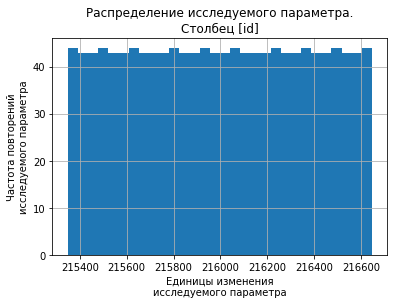

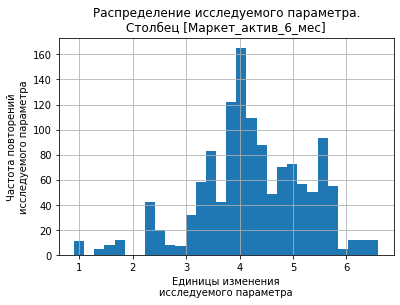

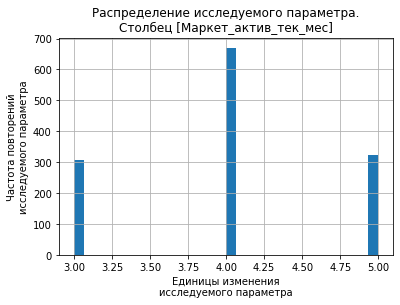

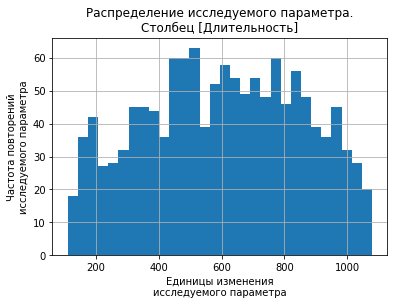

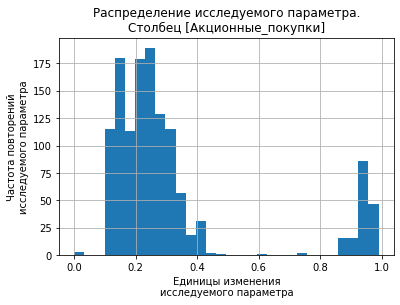

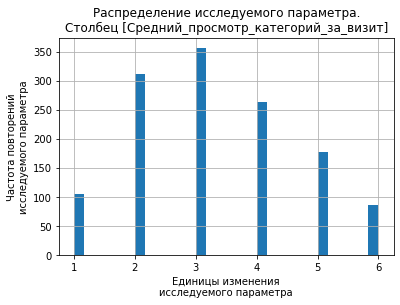

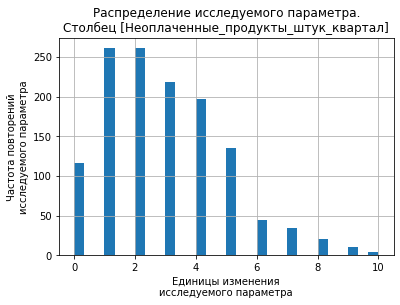

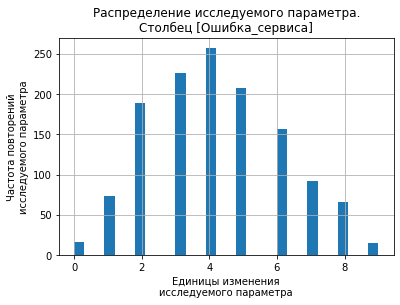

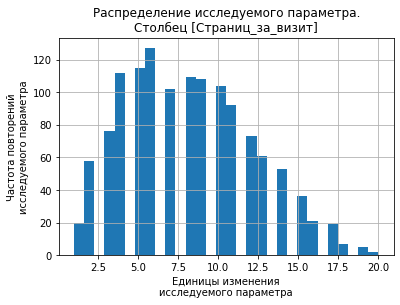

In [29]:
overview_plot(data_main)

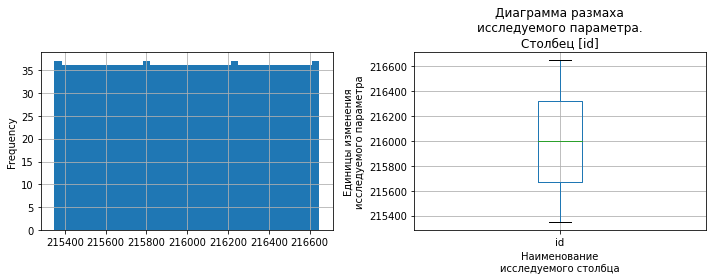

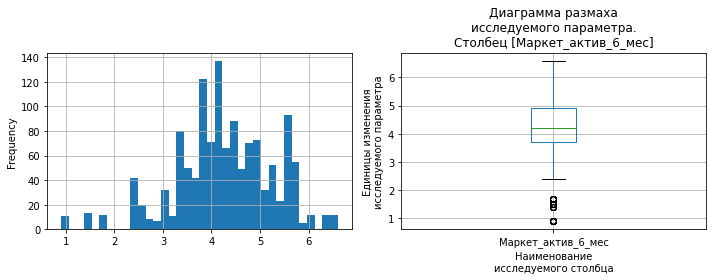

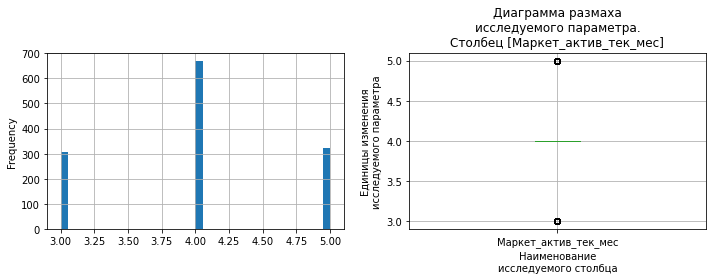

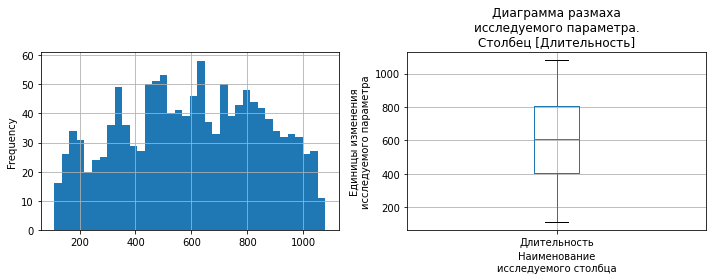

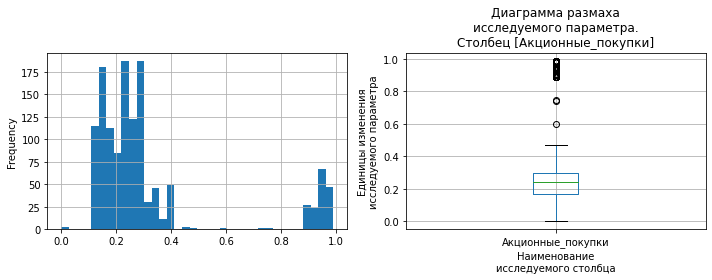

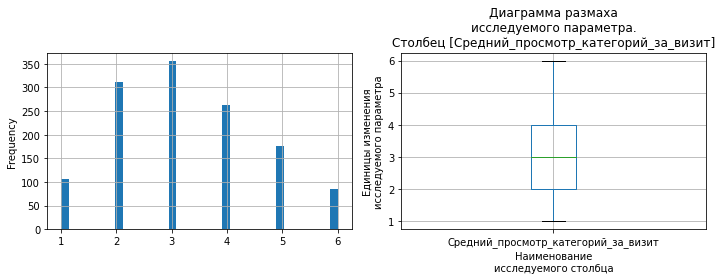

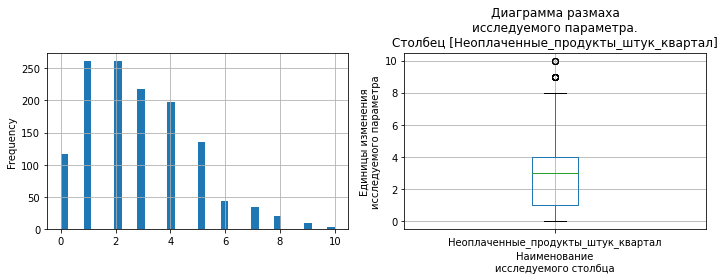

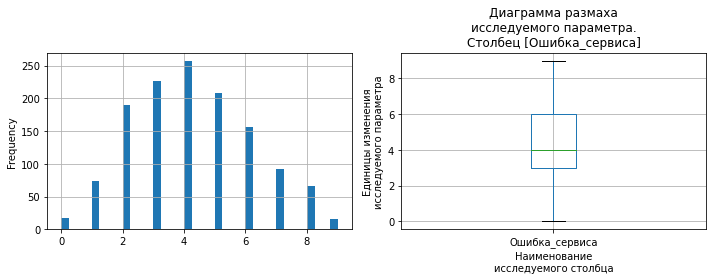

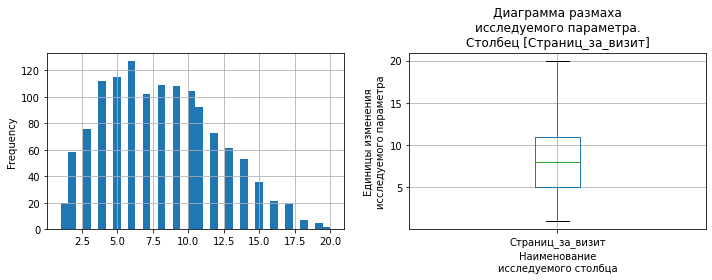

In [30]:
overview_plot_new(data_main)

Дополнительные выводы:
- столбец "id" представляет собой ключевой столбец с равномерно возрастающими уникальными кодами пользователей;
- аномалии и выбросы не замечены.

Дополнительные выводы:
- столбец "id" представляет собой ключевой столбец с равномерно возрастающими уникальными кодами пользователей. _Будем использовать его для объединения таблиц. В будущем столбец будет преобразован в индекс и удален_;
- аномалии и выбросы не замечены.

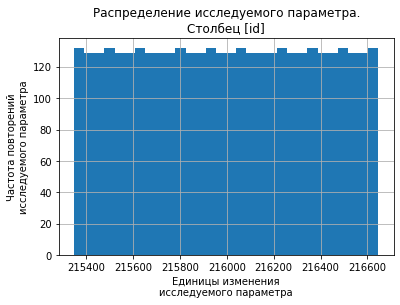

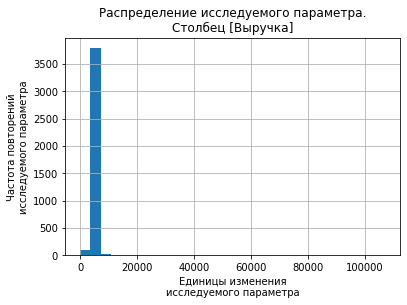

In [31]:
overview_plot(data_money)

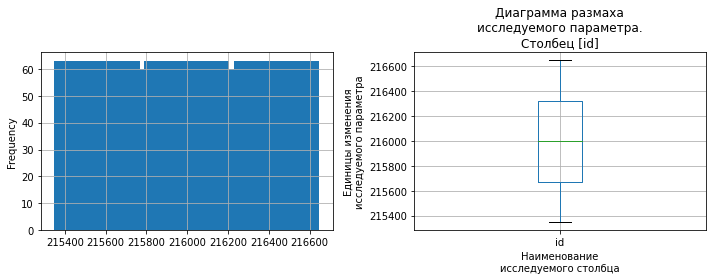

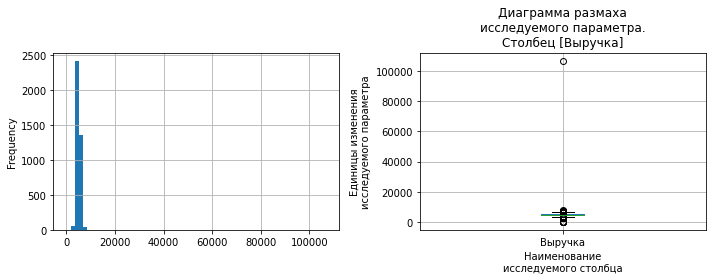

In [32]:
overview_plot_new(data_money)

Дополнительные выводы:
- столбец "id" представляет собой ключевой столбец с равномерно возрастающими уникальными кодами пользователей;
- возможны выбросы или аномальные значения выручки от единичных пользователей, необходима дополнительная проверка.

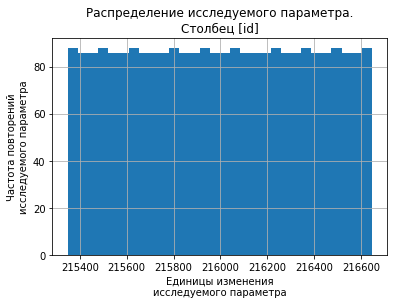

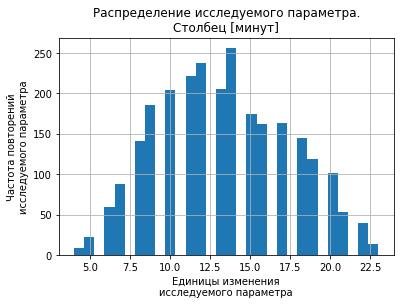

In [33]:
overview_plot(data_time)

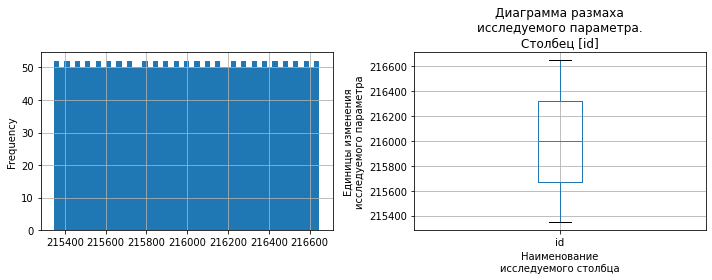

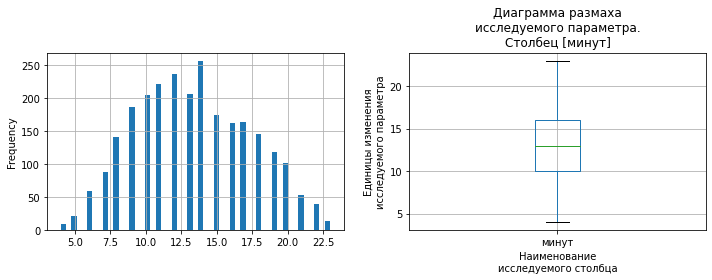

In [34]:
overview_plot_new(data_time)

In [35]:
bins_1 = int(np.round(math.log2(len(data_time['минут'])), 0)+1)
bins_2 = int(np.round(math.sqrt(len(data_time['минут'])), 0))

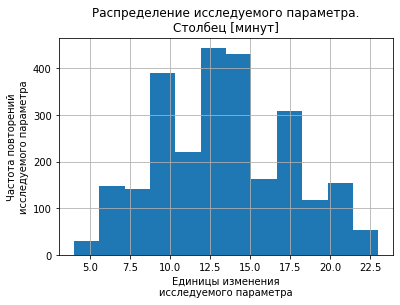

In [36]:
data_time['минут'].plot(kind='hist', bins=bins_1, grid=True, legend=False)
legend = '[' + 'минут' + ']'
plt.title('Распределение исследуемого параметра.\nСтолбец ' + legend)
plt.xlabel('Единицы изменения\nисследуемого параметра')
plt.ylabel('Частота повторений\nисследуемого параметра')
plt.show()

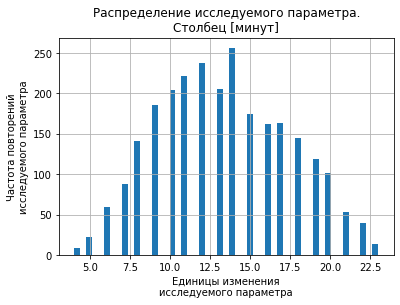

In [37]:
data_time['минут'].plot(kind='hist', bins=bins_2, grid=True, legend=False)
legend = '[' + 'минут' + ']'
plt.title('Распределение исследуемого параметра.\nСтолбец ' + legend)
plt.xlabel('Единицы изменения\nисследуемого параметра')
plt.ylabel('Частота повторений\nисследуемого параметра')
plt.show()

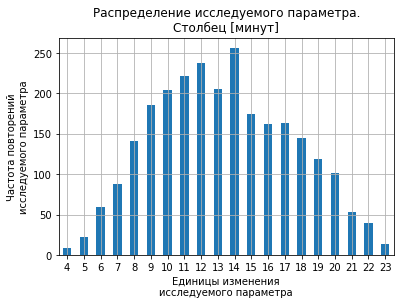

In [38]:
(
    data_time
    .pivot_table(index='минут', values='id', aggfunc='count')
    .plot(kind='bar', grid=True, legend=False, rot=0)
)
legend = '[' + 'минут' + ']'
plt.title('Распределение исследуемого параметра.\nСтолбец ' + legend)
plt.xlabel('Единицы изменения\nисследуемого параметра')
plt.ylabel('Частота повторений\nисследуемого параметра')
plt.show()

Дополнительные выводы:
- столбец "id" представляет собой ключевой столбец с равномерно возрастающими уникальными кодами пользователей;
- аномалии и выбросы не замечены.

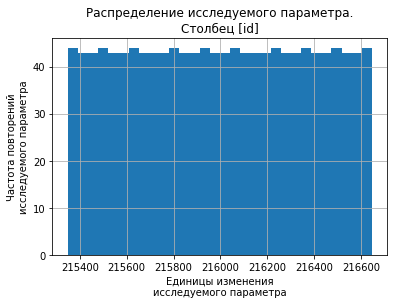

In [39]:
overview_plot(data_add_money)

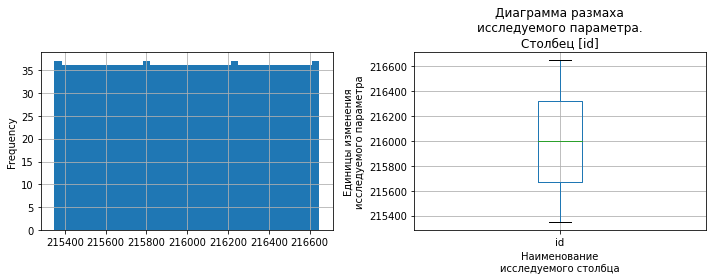

In [40]:
overview_plot_new(data_add_money)

Дополнительные выводы:
- столбец "id" представляет собой ключевой столбец с равномерно возрастающими уникальными кодами пользователей;
- в дата-сете на данный момент отсутствуют информативные численные столбцы. Будем их анализировать после приведения типов данных.

### Вывод по разделу "Загрузка и изучение входных данных"

В ходе изучения входных данных были сделаны следующие выводы:

На основании общих сведений о входных данных сделаем выводы об их полноте и качестве для целей исследования:
1. Для удобства работы целесообразно привести наименования столбцов всех таблиц к нижнему регистру и заменить пробелы на нижние подчеркивания.
2. Для ряда столбцов выглядят сомнительными их типы данных:
    - `Разрешить сообщать` таблицы `data_main` - тип данных должен быть boolean.
    - `Прибыль` таблицы `data_add_money` - тип данных должен быть float. Кроме того, значения в столбце `Прибыль` представлены строкой с разделителем запятая. Необходимо заменить на точку.
3. Очевидных пропусков в таблицах не имеется.
4. В столбцах `Покупательская активность` и `Популярная_категория`  таблицы `data_main` возможно наличие неявных дубликатов.
5. Столбцы `Период` таблиц `data_time` и `data_money` целесообразно проверить на наличие неявных дубликатов.
6. Значения столбцов `id` всех таблиц должны быть уникальными. Необходима проверка.
7. Таблицы целесообразно объединить по столбцу `id`, что позволит также обнаружить возможные пропуски.
8. В таблице `data_add_money` прибыль выражена в тысячах единиц, необходимо привести к единицам при работе с дополнительными данными.
9. В столбце Период замечена ошибка в значениях "предыдущий месяц".

## Шаг 2. Предобработка данных

Прозведем предобработку данных на основании ранее сделанных выводов:
1. Приведем наименования столбцов к нижнему регистру и заменим пробелы на нижние подчеркивания.
2. Изменим типы данных столбцов в соответствии с их содержанием.
3. Проверим предположение о наличии неявных дубликатов и обработаем их при необходимости.

Предварительно создадим копии входных данных для дальнейшей работы

In [41]:
copy_main = data_main.copy()
copy_money = data_money.copy()
copy_time = data_time.copy()
copy_add_money = data_add_money.copy()

### Обработка наименований столбцов

В ходе первичного ознакомления с данными была выявлена необходимость привести наименования столбцов к нижнему регистру и заменим пробелы на нижние подчеркивания.

In [42]:
copy_main = change_columnnames(copy_main)
copy_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [43]:
copy_money = change_columnnames(copy_money)
copy_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [44]:
copy_time = change_columnnames(copy_time)
copy_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [45]:
copy_add_money = change_columnnames(copy_add_money)
copy_add_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


### Обработка типов данных

В ходе первичного ознакомления с данными была выявлена необходимость изменения типов данных:
- `Разрешить сообщать` таблицы `data_main` - тип данных должен быть boolean или int со значениями 0 и 1.
- `Прибыль` таблицы `data_add_money` - тип данных должен быть float.

При этом, значения в столбце `Прибыль` представлены строкой с разделителем запятая. Необходимо заменить на точку.

In [46]:
copy_add_money['прибыль'] = copy_add_money['прибыль'].str.replace(',', '.')
try:
    copy_add_money['прибыль'] = copy_add_money['прибыль'].astype('float')
except Exception as e: print(e)  

In [47]:
copy_main['разрешить_сообщать'] = copy_main['разрешить_сообщать'].apply(lambda x: True if x == 'да' else False)
try:
    copy_main['разрешить_сообщать'] = copy_main['разрешить_сообщать'].astype('bool')
except Exception as e: print(e) 

Ошибок не возникло. Типы данных изменены.

### Обработка дубликатов

В ходе первичного ознакомления с данными было выявлено, что очевидных пропусков в таблицах не имеется. В связи с этим перейдем к обработке дубликатов:
1. Проверим наличе полных дубликатов и обработаем их при обнаружении.
2. В столбцах `Покупательская активность` и `Популярная_категория` таблицы `data_main`, а также `Период` таблиц `data_time` и `data_money` возможно наличие неявных дубликатов. Проверим их наличие и обработаем их при обнаружении.
3. Значения столбцов `id` всех таблиц должны быть уникальными. Необходима проверка.

Предварительно проверим наличие полных дубликатов в таблицах.

In [48]:
copy_main.duplicated().sum()

0

In [49]:
copy_money.duplicated().sum()

0

In [50]:
copy_time.duplicated().sum()

0

In [51]:
copy_add_money.duplicated().sum()

0

В таблицах не имеется полных дубликатов.

In [52]:
col_for_check = [
    'покупательская_активность',
    'тип_сервиса',
    'популярная_категория',
    'id'
]
check_duplicates(copy_main, col_for_check)

Проверяем столбец [покупательская_активность]
---> Количество уникальных значений: 2
---> Количество уникальных значений после приведения к нижнему регистру: 2
---> Уникальные значения: ['Снизилась' 'Прежний уровень']
%%%
Проверяем столбец [тип_сервиса]
---> Количество уникальных значений: 3
---> Количество уникальных значений после приведения к нижнему регистру: 3
---> Уникальные значения: ['премиум' 'стандартт' 'стандарт']
%%%
Проверяем столбец [популярная_категория]
---> Количество уникальных значений: 6
---> Количество уникальных значений после приведения к нижнему регистру: 6
---> Уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
%%%
Проверяем столбец [id]
---> Количество уникальных значений: 1300
---> Общее количество записей: 1300
%%%


В столбце `тип_сервиса` выявлены неявные дубликаты значений 'стандарт' и 'стандартт'. Исправим это.

In [53]:
copy_main['тип_сервиса'] = copy_main['тип_сервиса'].apply(lambda x: 'стандарт' if x == 'стандартт' else x)

In [54]:
col_for_check = [
    'период',
    'id'
]
check_duplicates(copy_time, col_for_check)

Проверяем столбец [период]
---> Количество уникальных значений: 2
---> Количество уникальных значений после приведения к нижнему регистру: 2
---> Уникальные значения: ['текущий_месяц' 'предыдцщий_месяц']
%%%
Проверяем столбец [id]
---> Количество уникальных значений: 1300
---> Общее количество записей: 2600
%%%


In [55]:
copy_time['период'] = copy_time['период'].apply(lambda x: 'предыдущий_месяц' if x == 'предыдцщий_месяц' else x)

In [56]:
check_duplicates(copy_money, col_for_check)

Проверяем столбец [период]
---> Количество уникальных значений: 3
---> Количество уникальных значений после приведения к нижнему регистру: 3
---> Уникальные значения: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
%%%
Проверяем столбец [id]
---> Количество уникальных значений: 1300
---> Общее количество записей: 3900
%%%


Неявных дубликатов не имеется.

Дополнительный вывод:
Данные о выручке и времени на сайте находятся в одном столбце для всех периодов. При объединении таблиц сделаем отдельный столбец для каждого периода.

### Вывод по разделу "Предобработка данных"

В ходе предобработки данных были достигнуты следующие результаты:

1. Не были обнаружены пропущенные значения.

2. Не были обнаружены полные, но были обнаружены неявные дубликаты в столбце `тип_сервиса` (дубликаты значений 'стандарт' и 'стандартт'). Дубликаты устранены. Кроме того, исправлена одна ошибка в значениях столбца `Период` таблицы `data_time`. Значения столбцов `id` всех таблиц должны быть уникальными (c учетом повторений значений для различных периодов).

3. Изменен тип данных в соответствии с их содержанием в столбце с численным показателем `Прибыль` таблицы `data_add_money` (тип данных должен быть float). Сведения в указанном столбце были представлены в виде строк с символами, которые не могут быть использованы при анализе и разработке моделей машинного обучения. Причиной появления данных с некорректными типами данных является принцип сбора и сохранения данных со стороны заказчика (использование запятой вместо точки в представлении дробных чисел).

4. Изменен тип данных в соответствии с их содержанием в столбце с бинарным признаком `Разрешить сообщать` таблицы `data_main` (тип данных должен быть boolean или int).

Предобработка данных завершена, данные готовы к дальнейшей очистки и анализу.

## Шаг 3. Исследовательский анализ данных

Проведем исследовательский анализ данных. В ходе анализа постараемся оценить:
1. Распределение элементов дата-сетов (коров) по категориальным признакам, применимость признаков для дальнейшей работы (достаточное распределение элемементов по признакам - репрезентативность).
2. Распределение количественных признаков, в том числе, тип распределений для дальнейшей работы по разработке моделей машинного обучения, наличие выбросов и аномальных значений.

**I. Для каждого столбца с категориальными признаками:**
1. Построим круговую диаграмму (если количество категорий не превышает 4) или столбчатую диаграмму для столбцов с количеством категорий более 4.
2. Оценим репрезентативность классов каждого признака. Оценим необходимость балансировки классов.

Исследуемые столбцы с категориальными признаками:
- таблица `copy_main`
    - `покупательская_активность`
    - `разрешить_сообщать`
    - `популярная_категория`
    
Для выполнения работ в соответствии с описанным подходом будем использовать созданные функции.

**II. Для каждого столбца с количественным параметром:**
1. Определим количественные характеристики распределений значений, построим гистрограммы и диаграммы размаха.
2. Определим выбросы. При необходимости более внимательно изучим выбросы в части их влияния на цель исследования и примем решение об их исправлении или удалении.<br>Основным критерием удаления выбросов определим их выход за пределы диаграммы размаха. При количестве строк с аномальными значениями менее 5% выборки, такие строки приоритетны к удалению, но может потребоваться дополнительный анализ.<br>При количестве выбросов более 5% их удаление производить не будем до исследования других параметров. Создадим запрос для использования метода query() в будущем с целью фильтрации данных.
3. После очистки данных изучим их распределение, визуализируем. Сделаем выводы.
4. Проверим нормальность распределения значений столбца.

Исследуемые столбцы с количественным параметром:
- таблица `copy_main`
    - `маркет_актив_6_мес`
    - `маркет_актив_тек_мес`
    - `длительность`
    - `акционные_покупки`
    - `средний_просмотр_категорий_за_визит`
    - `неоплаченные_продукты_штук_квартал`
    - `ошибка_сервиса`
    - `страниц_за_визит`
- таблица `copy_money` - для каждого из трех значений категории столбца "период"
    - `выручка`
- таблица `copy_time` - для каждого из двух значений категории столбца "период"
    - `минут`
- таблица `copy_add_money`
    - `прибыль`
    
Для выполнения работ будем использовать созданные функции, выводящие результаты анализа для категориальных признаков в соответствии с описанным выше подходом

### I. Исследование категориальных признаков

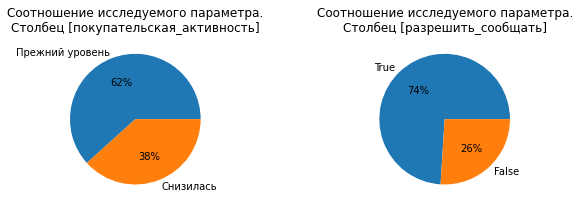

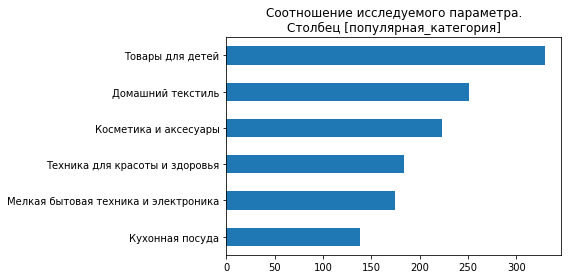

In [57]:
cat_names = [
    'покупательская_активность',
    'разрешить_сообщать',
    'популярная_категория',
]

analysis_cat_cols(copy_main, cat_names)

**Промежуточный вывод**

Важно отметить, что признак "разрешить_сообщать" играет важную роль в дальнейшей работе после завершения разработки моделей машинного обучения. Если модель предскажет снижение пользовательской активности, но пользователь запретил присылать ему дополнительные предложения, то необходимо искать другие методы повышения его активности. Предлагается использовать указанный признак для первоначального обучения модели и затем оценить его значимость. **Вероятно, от него придется отказаться и выбрать только пользователей, которые разрешили присылать дополнительные предложения.**

Один из исследуемых столбов является целевым признаком для разработки модели машинного обучения - столбец `покупательская_активность`. Разрабатываемая модель машинного обучения должна прогнозировать снизится ли покупательская активность пользователя, а именно:
- **класс 0 - "Прежний уровень" - для интернет-магазина хорошо;**
- **класс 1 - "Снизилась" - для интернет-магазина плохо.**

_(классы 0 и 1 будут присвоены в соответствии с документацией - By default, all labels in y_true and y_pred are used in sorted order. В сортированном порядке. "Прежний уровень" предшествует "Снизилась" при сортировке, поэтому "Прежний уровень" - 0, "Снизилась" - 1)._

При разработке машинного обучения будем особое внимание обращать на ошибку **второго** рода - ложно-отрицательную (FN):
- если модель МО предскажет 0 ("прежний уровень"), но ошибется, то пользователь не получит дополнительного предложения и мы его потеряем.
- если модель МО предскажет 1 ("снизилась"), но ошибется, то мы бы его не все равно не потеряли, но он получит дополнительное предложение. Вероятно, это может отпугнуть его (если пользователь не разрешил присылать ему дополнительные предложения), но сведений об этом не имеется.

В связи с этим, предлагается оценивать метрику _recall_. В то же время, конкретных указаний о минимизации ложно-отрицательной ошибки не имеется. В связи с этим постараемся найти оптимальный баланс модели, при котором она будет допускать приемлемое число ошибок обоих родов. Для этого будем оценивать метрику ROC-AUC, всеохватывающую метрику качества классификации, которая учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного.

Кроме того, при подборе гиперпараметров будем использовать метрику TPR True positive rate, которая рассчитывается также, как и recall. Указанную метрику создадим самостоятельно, поскольку дефолтный расчет recall для лексографических категорий не работает.

Для многоклассового признака в столбце `популярная_категория` также имеется дисбаланс, но считаем его менее важным, обработка не требуется.

### II. Исследование количественных признаков

Исследуем столбцы с количественным параметром:
- таблица `copy_main`
    - `маркет_актив_6_мес`
    - `маркет_актив_тек_мес`
    - `длительность`
    - `акционные_покупки`
    - `средний_просмотр_категорий_за_визит`
    - `неоплаченные_продукты_штук_квартал`
    - `ошибка_сервиса`
    - `страниц_за_визит`
- таблица `copy_money` - для каждого из трех значений категории столбца "период".
    - `выручка`
- таблица `copy_time` - для каждого из трех значений категории столбца "период".
    - `минут`
- таблица `copy_add_money` - для каждого из трех значений категории столбца "период".
    - `прибыль`

**Столбец `маркет_актив_6_мес` таблицы `copy_main`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

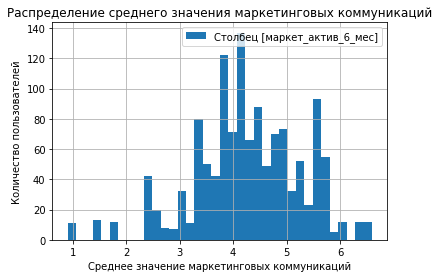


Ключевые характеристики распределения:
count    1300.00
mean        4.25
std         1.01
min         0.90
25%         3.70
50%         4.20
75%         4.90
max         6.60
Name: маркет_актив_6_мес, dtype: object

Ключевые характеристики диграммы размаха:
IQR			1.20
Q1-1,5*IQR		1.90
MIN диаграммы размаха	1.90
Q3+1,5*IQR		6.70
MAX диаграммы размаха	6.60



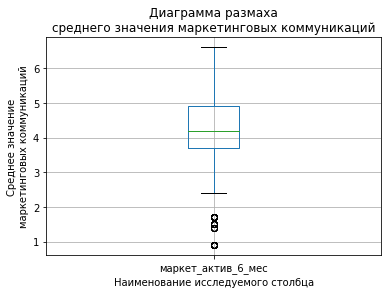

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	36
Доля выбросов (вниз)		2.77%


In [59]:
my_describe(
    copy_main, 'маркет_актив_6_мес',
    hist_desc=[
        'Распределение среднего значения маркетинговых коммуникаций',
        'Среднее значение маркетинговых коммуникаций',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсреднего значения маркетинговых коммуникаций',
        'Наименование исследуемого столбца',
        'Среднее значение\nмаркетинговых коммуникаций'
    ]
)

Выбросов вниз меньше выбранного порога. Однако, выведем выбросы, попробуем найти некоторую зависимость, поскольку на гистограмме выделяется 1-2 пика. Необходима дополнительная проверка.

In [60]:
copy_main[copy_main['маркет_актив_6_мес'] < 1.9].sample(7)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
389,215737,Снизилась,стандарт,True,0.9,4,225,0.36,Косметика и аксесуары,2,4,2,3
248,215596,Снизилась,стандарт,True,1.5,4,684,0.90,Косметика и аксесуары,3,0,2,4
269,215617,Снизилась,стандарт,True,0.9,4,728,0.90,Домашний текстиль,2,3,2,4
70,215418,Снизилась,стандарт,False,1.7,4,472,0.94,Домашний текстиль,2,6,4,3
1290,216638,Прежний уровень,стандарт,False,1.5,3,930,0.29,Мелкая бытовая техника и электроника,2,0,4,16
55,215403,Снизилась,премиум,True,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
272,215620,Снизилась,премиум,True,1.7,4,704,0.32,Косметика и аксесуары,1,6,3,4


Обнаружили, что представленные выбросы слишком похожи на реальные наблюдения. Аномальных значений не выявлено. Исходя из анализа предметной области не будем считать их выброса. Оставляем.

Проверим нормальность распределения

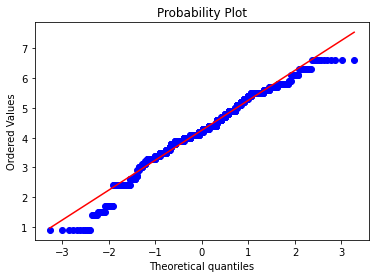

'p-value = 3.422309231294977e-12. Имеются основания говорить о НЕнормальности распределения'

In [61]:
is_norm(copy_main['маркет_актив_6_мес'])

Визуализируем очищенные данные

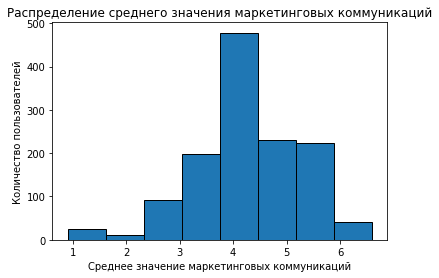

In [62]:
plt.hist(copy_main['маркет_актив_6_мес'], edgecolor='black', bins=8)
plt.title('Распределение среднего значения маркетинговых коммуникаций')
plt.xlabel('Среднее значение маркетинговых коммуникаций')
plt.ylabel('Количество пользователей')
plt.show()

In [63]:
my_describe(
    copy_main,
    'маркет_актив_6_мес',
    desc=['describe']
)


Ключевые характеристики распределения:
count    1300.00
mean        4.25
std         1.01
min         0.90
25%         3.70
50%         4.20
75%         4.90
max         6.60
Name: маркет_актив_6_мес, dtype: object


_**Вывод**_

В данных были обнаружены выбросы, однако не похожие на аномалии. Выявлены ключевые характеристики распределения среднего значения маркетинговых коммуникаций:
* среднее и медиана близки - 4.25 и 4.20;
* среднее значение маркетинговых коммуникаций 50% пользователей в диапазоне 3.70 - 4.90 ед.;
* минимальное значение - 0.90 ед., максимальное - 6.60 ед.

Имеются основания говорить, что распределение параметра **не нормально**.

**Столбец `маркет_актив_тек_мес` таблицы `copy_main`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

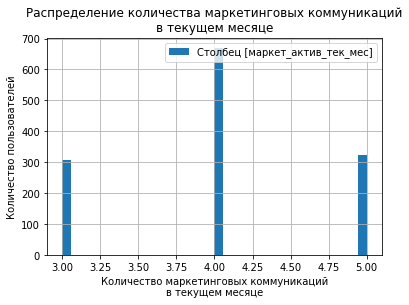


Ключевые характеристики распределения:
count    1300.00
mean        4.01
std         0.70
min         3.00
25%         4.00
50%         4.00
75%         4.00
max         5.00
Name: маркет_актив_тек_мес, dtype: object

Ключевые характеристики диграммы размаха:
IQR			0.00
Q1-1,5*IQR		4.00
MIN диаграммы размаха	4.00
Q3+1,5*IQR		4.00
MAX диаграммы размаха	4.00



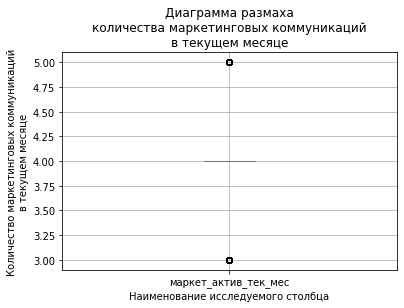

Ключевые характеристики выбросов:
Количество выбросов (вверх)	323
Доля выбросов (вверх)		24.85%
Количество выбросов (вниз)	308
Доля выбросов (вниз)		23.69%


In [64]:
my_describe(
    copy_main, 'маркет_актив_тек_мес',
    hist_desc=[
        'Распределение количества маркетинговых коммуникаций\nв текущем месяце',
        'Количество маркетинговых коммуникаций\nв текущем месяце',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nколичества маркетинговых коммуникаций\nв текущем месяце',
        'Наименование исследуемого столбца',
        'Количество маркетинговых коммуникаций\nв текущем месяце'
    ]
)

На основании анализа можно предположить, что указанный признак - мультклассовый категориальный. Однако, количество маркетинговых взаимдействий может быть и больше, чем представленные варианты. В связи с этим, предположение отметается и на наличие выбросов не будем обращать внимания. Визуализируем распределение пользователей аналогично категориальным признакам.

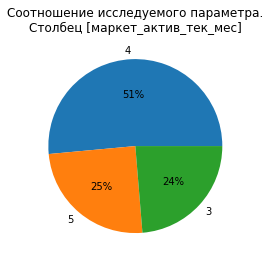

In [65]:
cat_names = [
    'маркет_актив_тек_мес'
]

analysis_cat_cols(copy_main, cat_names)

_**Вывод**_

В результате анализа выявлено, что половине всех пользователей в текущем месяце разослано рассылок, звонков, показов рекламы и прочего в количестве 4 единицы. По четверти пользователей получили по 3 и 5 маркетинговых коммуникаций.

**Столбец `длительность` таблицы `copy_main`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

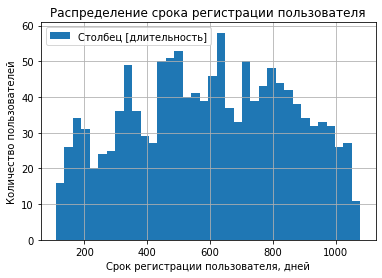


Ключевые характеристики распределения:
count    1300.00
mean      601.90
std       249.86
min       110.00
25%       405.50
50%       606.00
75%       806.00
max      1079.00
Name: длительность, dtype: object

Ключевые характеристики диграммы размаха:
IQR			400.50
Q1-1,5*IQR		-195.25
MIN диаграммы размаха	110.00
Q3+1,5*IQR		1406.75
MAX диаграммы размаха	1079.00



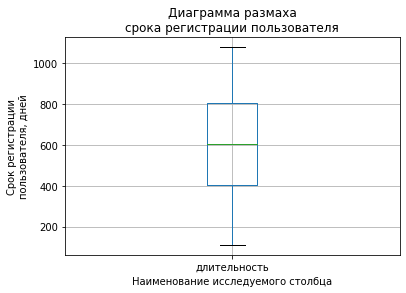

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [66]:
my_describe(
    copy_main, 'длительность',
    hist_desc=[
        'Распределение срока регистрации пользователя',
        'Срок регистрации пользователя, дней',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсрока регистрации пользователя',
        'Наименование исследуемого столбца',
        'Срок регистрации\nпользователя, дней'
    ]
)

Проверим нормальность распределения

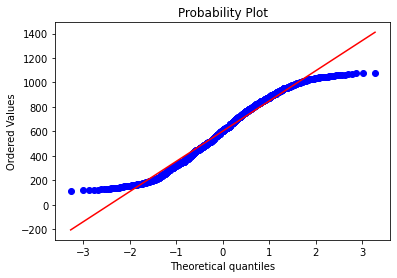

'p-value = 3.029317413882654e-60. Имеются основания говорить о НЕнормальности распределения'

In [67]:
is_norm(copy_main['длительность'])

Визуализируем очищенные данные

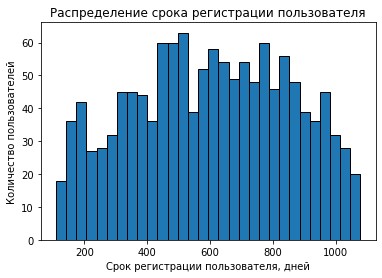

In [68]:
plt.hist(copy_main['длительность'], edgecolor='black', bins=30)
plt.title('Распределение срока регистрации пользователя')
plt.xlabel('Срок регистрации пользователя, дней')
plt.ylabel('Количество пользователей')
plt.show()

In [69]:
my_describe(
    copy_main,
    'длительность',
    desc=['describe']
)


Ключевые характеристики распределения:
count    1300.00
mean      601.90
std       249.86
min       110.00
25%       405.50
50%       606.00
75%       806.00
max      1079.00
Name: длительность, dtype: object


_**Вывод**_

Выбросов не обнаружено, очистка данных не потребовалась. Выявлены ключевые характеристики распределения срока регистрации пользователей:
* среднее и медиана близки - 602.36 и 604.50 дней;
* среднее значение срока регистрации пользователей 50% пользователей в диапазоне 405.50 - 808.00 дней;
* минимальное значение - 110.00 дней, максимальное - 1079.00 дней

Имеются основания говорить, что распределение параметра **не нормально**.

**Столбец `акционные_покупки` таблицы `copy_main`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

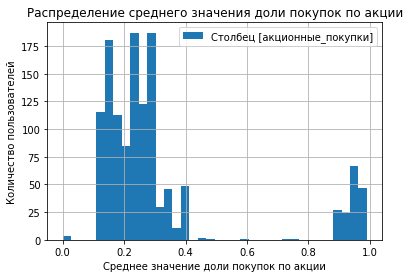


Ключевые характеристики распределения:
count    1300.00
mean        0.32
std         0.25
min         0.00
25%         0.17
50%         0.24
75%         0.30
max         0.99
Name: акционные_покупки, dtype: object

Ключевые характеристики диграммы размаха:
IQR			0.13
Q1-1,5*IQR		-0.02
MIN диаграммы размаха	0.00
Q3+1,5*IQR		0.49
MAX диаграммы размаха	0.49



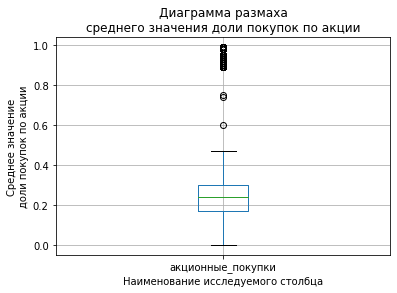

Ключевые характеристики выбросов:
Количество выбросов (вверх)	168
Доля выбросов (вверх)		12.92%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [70]:
my_describe(
    copy_main, 'акционные_покупки',
    hist_desc=[
        'Распределение среднего значения доли покупок по акции',
        'Среднее значение доли покупок по акции',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсреднего значения доли покупок по акции',
        'Наименование исследуемого столбца',
        'Среднее значение\nдоли покупок по акции'
    ]
)

Выявлено очень много выбросов, при этом, на гистограмме видны два пика. Возможно, это можно рассматривать как две сегмента пользователей. Выбросу удалять не будем. 

Кроме того, возможно отдельно выделить сегмент пользователей, не совершающих покупки акционных товаров.

В связи с этим, сформируем новый столбец, отражающий сегментирование пользователей и сформируем сводную таблицу для отображения количества пользователей различных сегментов.

In [71]:
copy_main['сегменты_по_акциям'] = copy_main['акционные_покупки'].apply(create_range_categories)
copy_main

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,сегменты_по_акциям
0,215348,Снизилась,премиум,True,3.4,5,121,0.00,Товары для детей,6,2,1,5,Не участвует
1,215349,Снизилась,премиум,True,4.4,4,819,0.75,Товары для детей,4,4,2,5,Часто участвует
2,215350,Снизилась,стандарт,False,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,Мало участвует
3,215351,Снизилась,стандарт,True,3.2,5,896,0.99,Товары для детей,5,0,6,4,Часто участвует
4,215352,Снизилась,стандарт,False,5.1,3,1064,0.94,Товары для детей,3,2,3,2,Часто участвует
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,True,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,Мало участвует
1296,216644,Прежний уровень,стандарт,False,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,Мало участвует
1297,216645,Прежний уровень,стандарт,True,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,Мало участвует
1298,216646,Прежний уровень,стандарт,True,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,Мало участвует


In [72]:
segments_sales = (
    copy_main
    .pivot_table(
        index='сегменты_по_акциям',
        values='id',
        aggfunc='count')
)
segments_sales

,id
сегменты_по_акциям,
Мало участвует,1129
Не участвует,3
Часто участвует,168


Троих не участвующих в акциях пользователей предлагается исключить из рассмотрения, поскольку для них может быть неактуальна рассылка персонизированных предложений.

In [73]:
copy_main = copy_main[copy_main['акционные_покупки'] != 0]
copy_main

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,сегменты_по_акциям
1,215349,Снизилась,премиум,True,4.4,4,819,0.75,Товары для детей,4,4,2,5,Часто участвует
2,215350,Снизилась,стандарт,False,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,Мало участвует
3,215351,Снизилась,стандарт,True,3.2,5,896,0.99,Товары для детей,5,0,6,4,Часто участвует
4,215352,Снизилась,стандарт,False,5.1,3,1064,0.94,Товары для детей,3,2,3,2,Часто участвует
5,215353,Снизилась,стандарт,True,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,Мало участвует
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,True,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,Мало участвует
1296,216644,Прежний уровень,стандарт,False,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,Мало участвует
1297,216645,Прежний уровень,стандарт,True,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,Мало участвует
1298,216646,Прежний уровень,стандарт,True,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,Мало участвует


_**Вывод**_

В результате анализа выявлено, что на основании данных столбца `акционные_покупки` пользователей можно разделить на два сегмента: часто покупающих по акции или редко. Трех пользователей, не участвующих в акциях было принято решение исключить из данных, поскольку для них может быть неактуальна рассылка персонизированных предложений.

Создан новый признак в столбце `сегменты_по_акциям`. При разработке модели машинного обучения используем данный признак.

Распределение параметра **не нормально**.

**Столбец `средний_просмотр_категорий_за_визит` таблицы `copy_main`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

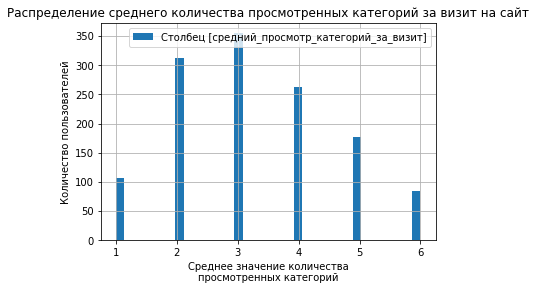


Ключевые характеристики распределения:
count    1297.00
mean        3.27
std         1.35
min         1.00
25%         2.00
50%         3.00
75%         4.00
max         6.00
Name: средний_просмотр_категорий_за_визит, dtype: object

Ключевые характеристики диграммы размаха:
IQR			2.00
Q1-1,5*IQR		-1.00
MIN диаграммы размаха	1.00
Q3+1,5*IQR		7.00
MAX диаграммы размаха	6.00



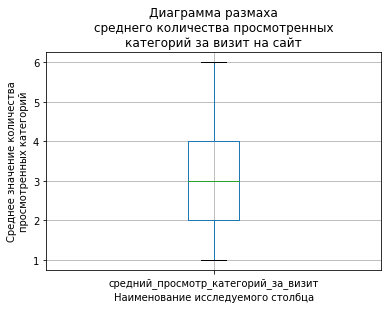

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [74]:
my_describe(
    copy_main, 'средний_просмотр_категорий_за_визит',
    hist_desc=[
        'Распределение среднего количества просмотренных категорий за визит на сайт',
        'Среднее значение количества\nпросмотренных категорий',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсреднего количества просмотренных\nкатегорий за визит на сайт',
        'Наименование исследуемого столбца',
        'Среднее значение количества\nпросмотренных категорий'
    ]
)

Визуализируем данные

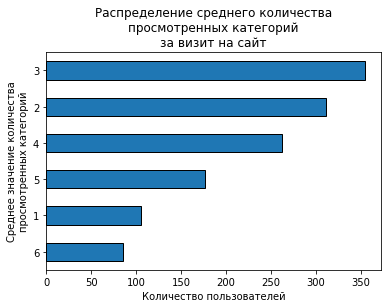

In [75]:
copy_main['средний_просмотр_категорий_за_визит'].value_counts(ascending=True).plot(
    kind = 'barh', 
    edgecolor='black',
)   
plt.title('Распределение среднего количества\nпросмотренных категорий\nза визит на сайт')
plt.ylabel('Среднее значение количества\nпросмотренных категорий')
plt.xlabel('Количество пользователей')
plt.show()

_**Вывод**_

В результате анализа выявлено, что больше всего пользователей за один визит просматривает 3 категории товаров, меньше пользователей просматривают 2 и 4 категории и еще меньше, соответственно, 1 и 6 категорий.

Распределение дискретной случайной величины - Распределение Пуассона.

**Столбец `неоплаченные_продукты_штук_квартал` таблицы `copy_main`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

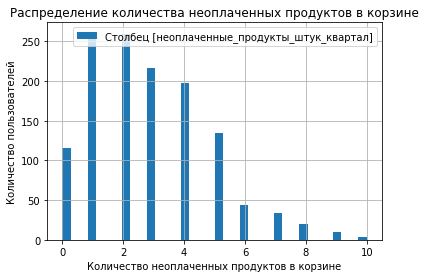


Ключевые характеристики распределения:
count    1297.00
mean        2.84
std         1.97
min         0.00
25%         1.00
50%         3.00
75%         4.00
max        10.00
Name: неоплаченные_продукты_штук_квартал, dtype: object

Ключевые характеристики диграммы размаха:
IQR			3.00
Q1-1,5*IQR		-3.50
MIN диаграммы размаха	0.00
Q3+1,5*IQR		8.50
MAX диаграммы размаха	8.50



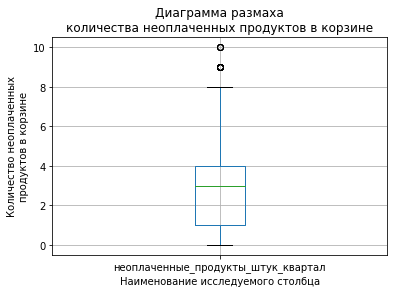

Ключевые характеристики выбросов:
Количество выбросов (вверх)	14
Доля выбросов (вверх)		1.08%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [76]:
my_describe(
    copy_main, 'неоплаченные_продукты_штук_квартал',
    hist_desc=[
        'Распределение количества неоплаченных продуктов в корзине',
        'Количество неоплаченных продуктов в корзине',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nколичества неоплаченных продуктов в корзине',
        'Наименование исследуемого столбца',
        'Количество неоплаченных\nпродуктов в корзине'
    ]
)

Выбросов вверх меньше выбранного порога. Однако, выведем выбросы, попробуем найти некоторую зависимость, поскольку на гистограмме выделяется 1-2 пика. Необходима дополнительная проверка.

In [77]:
copy_main[copy_main['неоплаченные_продукты_штук_квартал'] > 8.5].sample(7)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,сегменты_по_акциям
186,215534,Снизилась,премиум,False,4.0,4,419,0.93,Товары для детей,1,9,3,3,Часто участвует
176,215524,Снизилась,стандарт,True,3.0,3,474,0.23,Техника для красоты и здоровья,1,10,4,2,Мало участвует
251,215599,Снизилась,стандарт,True,3.4,4,716,0.28,Домашний текстиль,2,9,4,6,Мало участвует
348,215696,Снизилась,премиум,True,3.4,3,384,0.98,Кухонная посуда,1,9,4,3,Часто участвует
246,215594,Снизилась,стандарт,True,4.2,4,627,0.90,Товары для детей,6,9,5,8,Часто участвует
320,215668,Снизилась,премиум,True,4.4,4,343,0.94,Товары для детей,2,9,2,2,Часто участвует
72,215420,Снизилась,стандарт,True,3.5,5,449,0.35,Домашний текстиль,1,9,2,2,Мало участвует


Обнаружили, что представленные выбросы слишком похожи на реальные наблюдения. Аномальных значений не выявлено. Исходя из анализа предметной области не будем считать их выброса. Оставляем.

Визуализируем данные

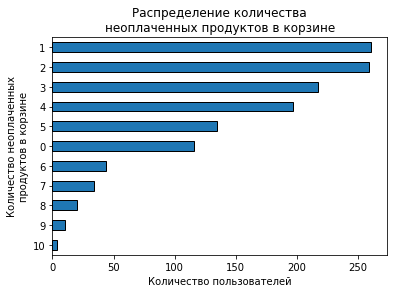

In [78]:
copy_main['неоплаченные_продукты_штук_квартал'].value_counts(ascending=True).plot(
    kind = 'barh', 
    edgecolor='black',
)   
plt.title('Распределение количества\nнеоплаченных продуктов в корзине')
plt.ylabel('Количество неоплаченных\nпродуктов в корзине')
plt.xlabel('Количество пользователей')
plt.show()

_**Вывод**_

В результате анализа выявлено, что больше всего пользователей имеют один неоплаченный товар в корзине. Наименьшее количество пользователей имеют более 6 неоплаченных товаров.

Распределение дискретной случайной величины - Распределение Пуассона.

**Столбец `ошибка_сервиса` таблицы `copy_main`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

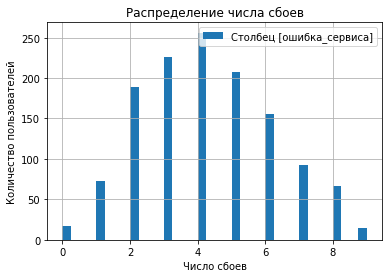


Ключевые характеристики распределения:
count    1297.00
mean        4.18
std         1.95
min         0.00
25%         3.00
50%         4.00
75%         6.00
max         9.00
Name: ошибка_сервиса, dtype: object

Ключевые характеристики диграммы размаха:
IQR			3.00
Q1-1,5*IQR		-1.50
MIN диаграммы размаха	0.00
Q3+1,5*IQR		10.50
MAX диаграммы размаха	9.00



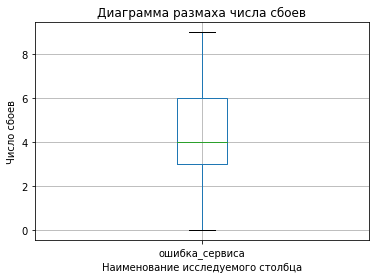

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [79]:
my_describe(
    copy_main, 'ошибка_сервиса',
    hist_desc=[
        'Распределение числа сбоев',
        'Число сбоев',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха числа сбоев',
        'Наименование исследуемого столбца',
        'Число сбоев'
    ]
)

Визуализируем данные

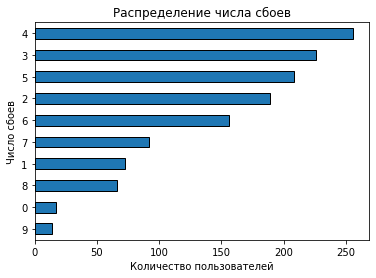

In [80]:
copy_main['ошибка_сервиса'].value_counts(ascending=True).plot(
    kind = 'barh', 
    edgecolor='black',
)   
plt.title('Распределение числа сбоев')
plt.ylabel('Число сбоев')
plt.xlabel('Количество пользователей')
plt.show()

_**Вывод**_

В результате анализа выявлено, что больше всего пользователей сталкивается с 4 сбоями. Пользователей, которые не сталкивались со сбоями немного.

Распределение дискретной случайной величины - Распределение Пуассона.

**Столбец `страниц_за_визит` таблицы `copy_main`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

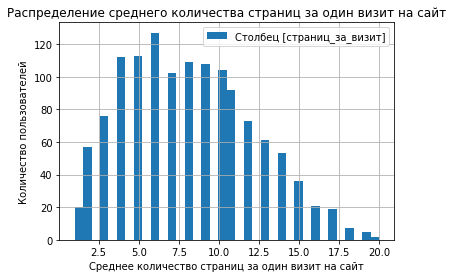


Ключевые характеристики распределения:
count    1297.00
mean        8.19
std         3.98
min         1.00
25%         5.00
50%         8.00
75%        11.00
max        20.00
Name: страниц_за_визит, dtype: object

Ключевые характеристики диграммы размаха:
IQR			6.00
Q1-1,5*IQR		-4.00
MIN диаграммы размаха	1.00
Q3+1,5*IQR		20.00
MAX диаграммы размаха	20.00



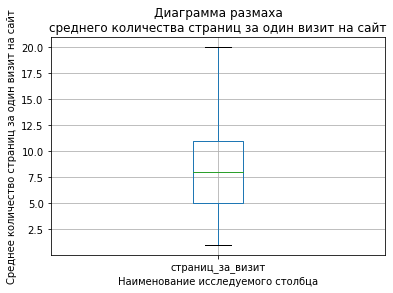

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [81]:
my_describe(
    copy_main, 'страниц_за_визит',
    hist_desc=[
        'Распределение среднего количества страниц за один визит на сайт',
        'Среднее количество страниц за один визит на сайт',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсреднего количества страниц за один визит на сайт',
        'Наименование исследуемого столбца',
        'Среднее количество страниц за один визит на сайт'
    ]
)

Визуализируем данные

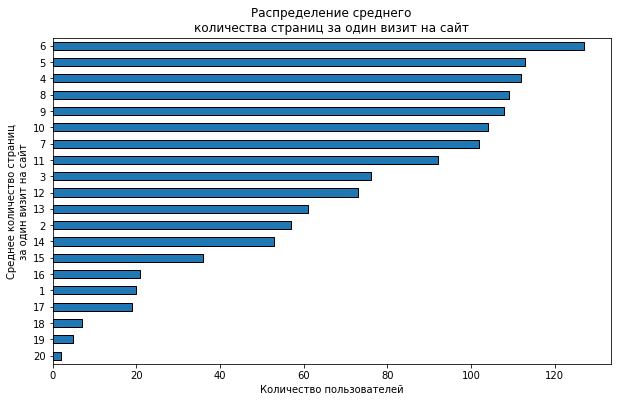

In [82]:
copy_main['страниц_за_визит'].value_counts(ascending=True).plot(
    kind = 'barh', 
    edgecolor='black',
    figsize=(10,6)
)   
plt.title('Распределение среднего\nколичества страниц за один визит на сайт')
plt.ylabel('Среднее количество страниц\nза один визит на сайт')
plt.xlabel('Количество пользователей')
plt.show()

_**Вывод**_

В результате анализа выявлено, что больше всего пользователей просматривает 6 страниц за один визит. Пользователей, которые не сталкивались со сбоями немного.

Распределение дискретной случайной величины - Распределение Пуассона.

Для дальнейшего анализа дополнительных таблиц определим перечень пользователей, представленный в основной таблице.

In [83]:
ids = copy_main['id'].unique()
ids

array([215349, 215350, 215351, ..., 216645, 216646, 216647])

In [84]:
copy_main.shape

(1297, 14)

**Столбец `выручка` таблицы `copy_money`**

В ходе предварительного изучения данных было выявлено, что в столбце `период` представлены три различных периода. Целесообразно разделить столбец выручка по этим периодам.

In [85]:
columns = []
for name in copy_money['период'].unique():
    name = 'выручка' + '_' + name
    columns.append(name)
money_modified = pd.crosstab(copy_money['id'], copy_money['период'], values=copy_money['выручка'], aggfunc=lambda x: x)
money_modified.columns = columns
money_modified = money_modified.reset_index()
money_modified

,id,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
...,...,...,...,...
1295,216643,3664.0,4704.0,4741.7
1296,216644,4729.0,5299.0,5353.0
1297,216645,5160.0,5334.0,5139.2
1298,216646,4923.0,4725.0,5224.6


В рассматриваемых столбцах представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

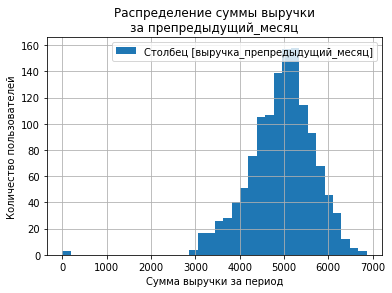


Ключевые характеристики распределения:
count    1300.00
mean     4936.92
std       739.60
min         0.00
25%      4496.75
50%      5005.00
75%      5405.62
max      6869.50
Name: выручка_препредыдущий_месяц, dtype: object

Ключевые характеристики диграммы размаха:
IQR			908.88
Q1-1,5*IQR		3133.44
MIN диаграммы размаха	3133.44
Q3+1,5*IQR		6768.94
MAX диаграммы размаха	6768.94



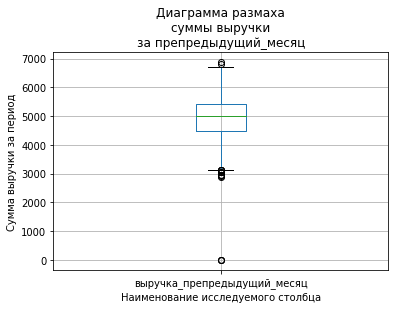

Ключевые характеристики выбросов:
Количество выбросов (вверх)	2
Доля выбросов (вверх)		0.15%
Количество выбросов (вниз)	13
Доля выбросов (вниз)		1.00%


In [86]:
my_describe(
    money_modified, 'выручка_препредыдущий_месяц',
    hist_desc=[
        'Распределение суммы выручки\nза препредыдущий_месяц',
        'Сумма выручки за период',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсуммы выручки\nза препредыдущий_месяц',
        'Наименование исследуемого столбца',
        'Сумма выручки за период'
    ]
)

Вывыдем минимальные выбросы и изучим их.

In [87]:
money_modified[money_modified['выручка_препредыдущий_месяц'] < 1000]

,id,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц
0,215348,0.0,0.0,3293.1
9,215357,0.0,0.0,5986.3
11,215359,0.0,0.0,4735.0


Проверим наличие указанных пользователей в таблице `copy_main` с использованием созданной функции

In [88]:
change_depended_data(
    money_modified.query('выручка_препредыдущий_месяц < 1000'),
    'id',
    [copy_main]
)

Проверяем запись: 215348
---> Проверяем таблицу [0] -> количество записей = 0
Проверяем запись: 215357
---> Проверяем таблицу [0] -> количество записей = 0
Проверяем запись: 215359
---> Проверяем таблицу [0] -> количество записей = 0


В таблице `copy_main` уже не имеется указанных пользователей. Они были удалены ранее. Удалим выбросы и из таблицы `money_modified`.

In [89]:
for id in money_modified.query('выручка_препредыдущий_месяц < 1000')['id'].unique():
    money_modified = money_modified[money_modified['id'] != id]
money_modified.shape

(1297, 4)

Повторим анализ

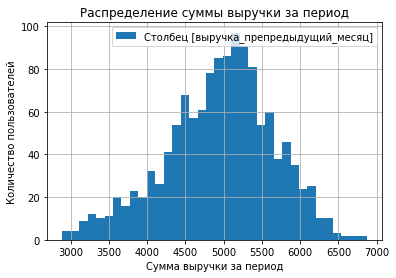


Ключевые характеристики распределения:
count    1297.00
mean     4948.34
std       701.23
min      2890.00
25%      4498.50
50%      5005.50
75%      5409.00
max      6869.50
Name: выручка_препредыдущий_месяц, dtype: object

Ключевые характеристики диграммы размаха:
IQR			910.50
Q1-1,5*IQR		3132.75
MIN диаграммы размаха	3132.75
Q3+1,5*IQR		6774.75
MAX диаграммы размаха	6774.75



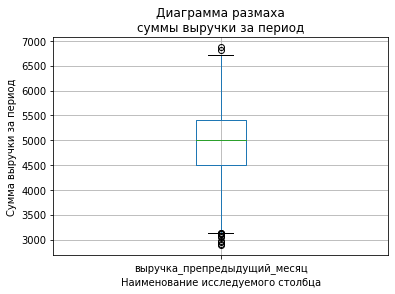

Ключевые характеристики выбросов:
Количество выбросов (вверх)	2
Доля выбросов (вверх)		0.15%
Количество выбросов (вниз)	10
Доля выбросов (вниз)		0.77%


In [90]:
my_describe(
    money_modified, 'выручка_препредыдущий_месяц',
    hist_desc=[
        'Распределение суммы выручки за период',
        'Сумма выручки за период',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсуммы выручки за период',
        'Наименование исследуемого столбца',
        'Сумма выручки за период'
    ]
)

Выбросов меньше выбранного порога. Необходима дополнительная проверка.

In [91]:
money_modified[money_modified['выручка_препредыдущий_месяц'] > 6774.74]

,id,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц
23,215371,6809.0,4742.0,6937.7
87,215435,6869.5,5008.0,7605.3


In [92]:
change_depended_data(
    money_modified.query('выручка_препредыдущий_месяц > 6774.74'),
    'id',
    [copy_main]
)

Проверяем запись: 215371
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215435
---> Проверяем таблицу [0] -> количество записей = 1


In [93]:
money_modified[money_modified['выручка_препредыдущий_месяц'] < 3132.75]

,id,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц
130,215478,2960.0,4682.0,3078.3
181,215529,3111.0,4449.0,3267.0
216,215564,2890.0,4213.0,3334.6
220,215568,2909.0,4740.0,3933.4
337,215685,3130.0,4382.0,4345.5
368,215716,3067.0,4165.0,3343.9
547,215895,3130.0,4382.0,4345.5
770,216118,3111.0,4462.0,4412.3
1097,216445,3061.0,4351.0,4309.0
1286,216634,2970.0,4342.0,4289.5


In [94]:
change_depended_data(
    money_modified.query('выручка_препредыдущий_месяц < 3132.75'),
    'id',
    [copy_main]
)

Проверяем запись: 215478
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215529
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215564
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215568
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215685
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215716
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215895
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 216118
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 216445
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 216634
---> Проверяем таблицу [0] -> количество записей = 1


Обнаружили, что представленные выбросы слишком похожи на реальные наблюдения. Аномальных значений не выявлено. Исходя из анализа предметной области не будем считать их выброса. Оставляем.

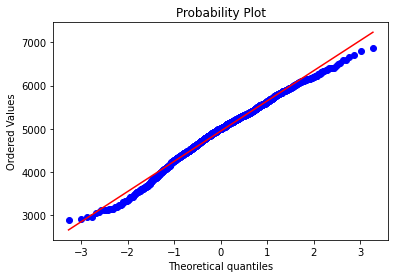

'p-value = 6.318723481254675e-06. Имеются основания говорить о НЕнормальности распределения'

In [95]:
is_norm(money_modified['выручка_препредыдущий_месяц'])

Проверим следующий период

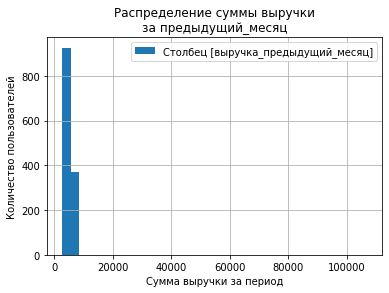


Ключевые характеристики распределения:
count      1297.00
mean       5316.45
std        2942.47
min        2758.70
25%        4706.60
50%        5180.30
75%        5761.30
max      106862.20
Name: выручка_предыдущий_месяц, dtype: object

Ключевые характеристики диграммы размаха:
IQR			1054.70
Q1-1,5*IQR		3124.55
MIN диаграммы размаха	3124.55
Q3+1,5*IQR		7343.35
MAX диаграммы размаха	7343.35



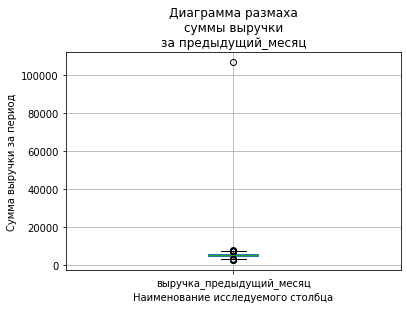

Ключевые характеристики выбросов:
Количество выбросов (вверх)	11
Доля выбросов (вверх)		0.85%
Количество выбросов (вниз)	5
Доля выбросов (вниз)		0.39%


In [96]:
my_describe(
    money_modified, 'выручка_предыдущий_месяц',
    hist_desc=[
        'Распределение суммы выручки\nза предыдущий_месяц',
        'Сумма выручки за период',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсуммы выручки\nза предыдущий_месяц',
        'Наименование исследуемого столбца',
        'Сумма выручки за период'
    ]
)

Вывыдем максимальные выбросы и изучим их.

In [97]:
money_modified[money_modified['выручка_предыдущий_месяц'] > 20000]

,id,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц
32,215380,6077.0,5051.0,106862.2


In [98]:
change_depended_data(
    money_modified.query('выручка_предыдущий_месяц > 20000'),
    'id',
    [copy_main, money_modified]
)

Проверяем запись: 215380
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1


In [99]:
copy_main, money_modified = change_depended_data(
    money_modified.query('выручка_предыдущий_месяц > 20000'),
    'id',
    [copy_main, money_modified],
    method='delete'
)

Удаляем запись: 215380
---> Удаляем запись из таблицы [0] -> количество записей = 1
------> Запись удалена
---> Удаляем запись из таблицы [1] -> количество записей = 1
------> Запись удалена


В таблице `copy_main` уже не имеется указанных пользователей. Они были удалены ранее. Удалим выбросы и из таблицы `money_modified`.

In [100]:
money_modified = money_modified.query('выручка_предыдущий_месяц < 20000')

Повторим анализ

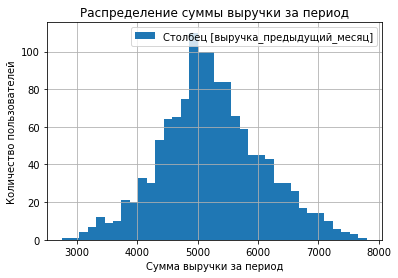


Ключевые характеристики распределения:
count    1296.00
mean     5238.10
std       834.32
min      2758.70
25%      4706.05
50%      5179.95
75%      5759.28
max      7799.40
Name: выручка_предыдущий_месяц, dtype: object

Ключевые характеристики диграммы размаха:
IQR			1053.23
Q1-1,5*IQR		3126.21
MIN диаграммы размаха	3126.21
Q3+1,5*IQR		7339.11
MAX диаграммы размаха	7339.11



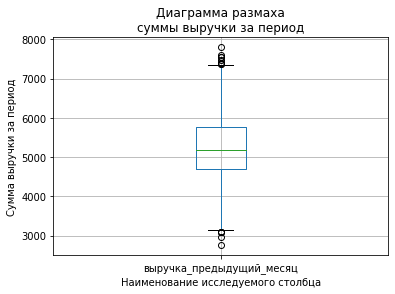

Ключевые характеристики выбросов:
Количество выбросов (вверх)	10
Доля выбросов (вверх)		0.77%
Количество выбросов (вниз)	5
Доля выбросов (вниз)		0.39%


In [101]:
my_describe(
    money_modified, 'выручка_предыдущий_месяц',
    hist_desc=[
        'Распределение суммы выручки за период',
        'Сумма выручки за период',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсуммы выручки за период',
        'Наименование исследуемого столбца',
        'Сумма выручки за период'
    ]
)

Обнаружили, что представленные выбросы слишком похожи на реальные наблюдения. Аномальных значений не выявлено. Исходя из анализа предметной области не будем считать их выброса. Оставляем.

In [102]:
change_depended_data(
    money_modified.query('выручка_предыдущий_месяц > 7339.11'),
    'id',
    [copy_main]
)

Проверяем запись: 215435
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215493
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215536
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215682
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215841
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215872
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215892
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 216103
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 216144
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 216322
---> Проверяем таблицу [0] -> количество записей = 1


In [103]:
change_depended_data(
    money_modified.query('выручка_предыдущий_месяц < 3126.21'),
    'id',
    [copy_main]
)

Проверяем запись: 215466
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215478
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 215560
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 216176
---> Проверяем таблицу [0] -> количество записей = 1
Проверяем запись: 216442
---> Проверяем таблицу [0] -> количество записей = 1


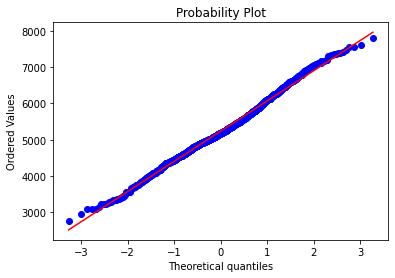

'p-value = 0.032576660983625105. Имеются основания говорить о НЕнормальности распределения'

In [104]:
is_norm(money_modified['выручка_предыдущий_месяц'])

Проверим следующий период

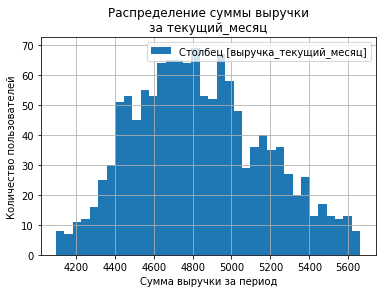


Ключевые характеристики распределения:
count    1296.00
mean     4836.20
std       333.51
min      4098.00
25%      4584.50
50%      4810.50
75%      5056.00
max      5663.00
Name: выручка_текущий_месяц, dtype: object

Ключевые характеристики диграммы размаха:
IQR			471.50
Q1-1,5*IQR		3877.25
MIN диаграммы размаха	4098.00
Q3+1,5*IQR		5763.25
MAX диаграммы размаха	5663.00



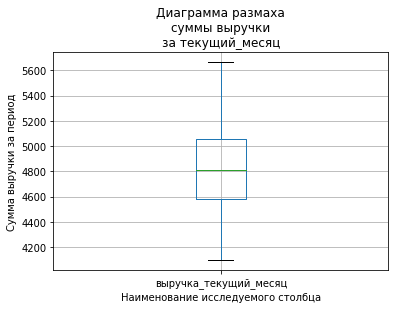

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [105]:
my_describe(
    money_modified, 'выручка_текущий_месяц',
    hist_desc=[
        'Распределение суммы выручки\nза текущий_месяц',
        'Сумма выручки за период',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nсуммы выручки\nза текущий_месяц',
        'Наименование исследуемого столбца',
        'Сумма выручки за период'
    ]
)

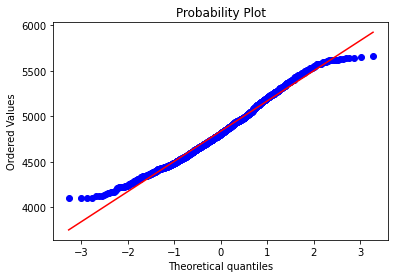

'p-value = 3.557708238376563e-10. Имеются основания говорить о НЕнормальности распределения'

In [106]:
is_norm(money_modified['выручка_текущий_месяц'])

Визуализируем очищенные данные

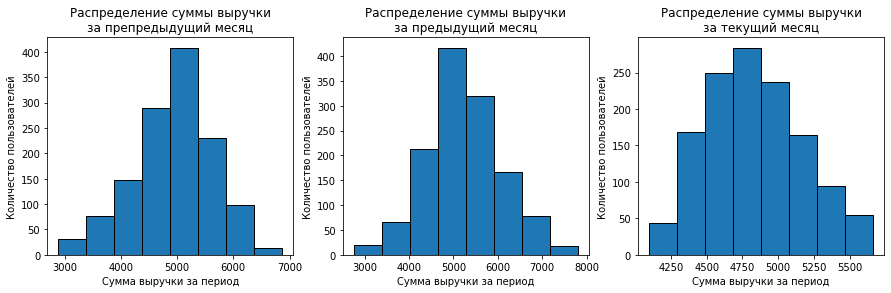


Представим все распределения на одном графике



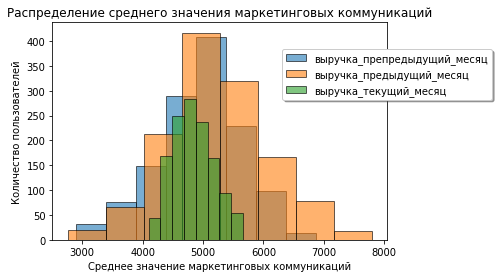

In [107]:
cols = ['выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i in range(0, len(cols)):
    money_modified[cols[i]].plot(kind='hist', edgecolor='black', bins=8, ax=axes[i])
    title = 'Распределение суммы выручки\nза ' + cols[i].replace('выручка_', '').replace('_', ' ')
    axes[i].set_title(title)
    axes[i].set_xlabel('Сумма выручки за период')
    axes[i].set_ylabel('Количество пользователей')
plt.show()

print()
print('Представим все распределения на одном графике')
print()

for i in range(0, len(cols)):
    money_modified[cols[i]].plot(kind='hist', edgecolor='black', bins=8, legend=True, alpha=0.6)
    plt.title('Распределение среднего значения маркетинговых коммуникаций')
    plt.xlabel('Среднее значение маркетинговых коммуникаций')
    plt.ylabel('Количество пользователей')

plt.legend(loc='upper center', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

In [108]:
for col in cols:
    my_describe(
        money_modified,
        col,
        desc=['describe']
    )


Ключевые характеристики распределения:
count    1296.00
mean     4947.47
std       700.80
min      2890.00
25%      4498.12
50%      5005.50
75%      5405.62
max      6869.50
Name: выручка_препредыдущий_месяц, dtype: object

Ключевые характеристики распределения:
count    1296.00
mean     5238.10
std       834.32
min      2758.70
25%      4706.05
50%      5179.95
75%      5759.28
max      7799.40
Name: выручка_предыдущий_месяц, dtype: object

Ключевые характеристики распределения:
count    1296.00
mean     4836.20
std       333.51
min      4098.00
25%      4584.50
50%      4810.50
75%      5056.00
max      5663.00
Name: выручка_текущий_месяц, dtype: object


_**Вывод**_

В результате анализа выявлено, что для каждого из трех периодов распределение выручки различно. Столбец таблицы с исходными данными был разделен на три столбца `выручка_препредыдущий_месяц`, `выручка_предыдущий_месяц` и `выручка_текущий_месяц`. В дальнейшей работе будем использовать таблицу `money_modified`.

Были обнаружены выбросы, однако не похожие на аномалии. При этом данные очищены от минимального количества пользователей с нулевой выручкой и слишком высокой (более 100000).

Выявлены ключевые характеристики распределения выручки пользователей за препредыдущий месяц:
* среднее и медиана близки - 4947.47 и 5005.50;
* среднее значение выручки от 50% пользователей в диапазоне 4498.12 - 5405.62;
* минимальное значение - 2890.00, максимальное - 6869.50

Имеются основания говорить, что распределение параметра **не нормально**.

Выявлены ключевые характеристики распределения выручки пользователей за предыдущий месяц:
* среднее и медиана близки - 5238.10 и 5179.95;
* среднее значение выручки от 50% пользователей в диапазоне 4706.05 - 5759.28;
* минимальное значение - 2758.70, максимальное - 7799.40

Имеются основания говорить, что распределение параметра **не нормально**.

Выявлены ключевые характеристики распределения выручки пользователей за текущий месяц:
* среднее и медиана близки - 4836.20 и 4810.50;
* среднее значение выручки от 50% пользователей в диапазоне 4584.50 - 5056.00;
* минимальное значение - 4098.00, максимальное - 5663.00

Имеются основания говорить, что распределение параметра **не нормально**.

**Столбец `минут` таблицы `copy_time`**

В ходе предварительного изучения данных было выявлено, что в столбце `период` представлены три различных периода. Целесообразно разделить столбец `минут` по этим периодам.

In [109]:
columns = []
for name in copy_time['период'].unique():
    name = 'минут' + '_' + name
    columns.append(name)
time_modified = pd.crosstab(copy_time['id'], copy_time['период'], values=copy_time['минут'], aggfunc=lambda x: x)
time_modified.columns = columns
time_modified = time_modified.reset_index()
time_modified

,id,минут_текущий_месяц,минут_предыдущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


В рассматриваемых столбцах представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

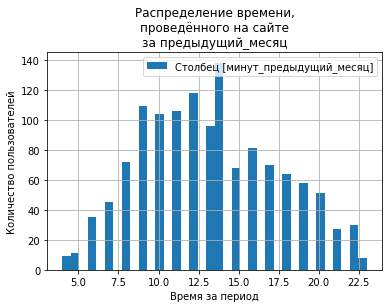


Ключевые характеристики распределения:
count    1300.00
mean       13.20
std         4.22
min         4.00
25%        10.00
50%        13.00
75%        16.00
max        23.00
Name: минут_предыдущий_месяц, dtype: object

Ключевые характеристики диграммы размаха:
IQR			6.00
Q1-1,5*IQR		1.00
MIN диаграммы размаха	4.00
Q3+1,5*IQR		25.00
MAX диаграммы размаха	23.00



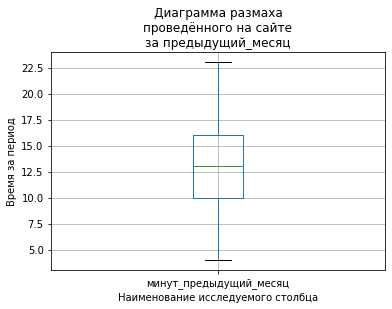

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [110]:
my_describe(
    time_modified, 'минут_предыдущий_месяц',
    hist_desc=[
        'Распределение времени,\nпроведённого на сайте\nза предыдущий_месяц',
        'Время за период',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nпроведённого на сайте\nза предыдущий_месяц',
        'Наименование исследуемого столбца',
        'Время за период'
    ]
)

В рассматриваемых столбцах представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции

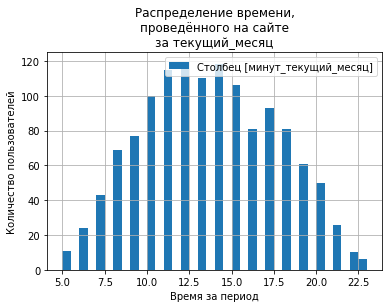


Ключевые характеристики распределения:
count    1300.00
mean       13.47
std         3.93
min         5.00
25%        11.00
50%        13.00
75%        17.00
max        23.00
Name: минут_текущий_месяц, dtype: object

Ключевые характеристики диграммы размаха:
IQR			6.00
Q1-1,5*IQR		2.00
MIN диаграммы размаха	5.00
Q3+1,5*IQR		26.00
MAX диаграммы размаха	23.00



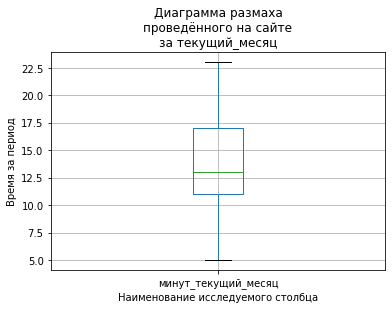

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [111]:
my_describe(
    time_modified, 'минут_текущий_месяц',
    hist_desc=[
        'Распределение времени,\nпроведённого на сайте\nза текущий_месяц',
        'Время за период',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nпроведённого на сайте\nза текущий_месяц',
        'Наименование исследуемого столбца',
        'Время за период'
    ]
)

Визуализируем данные

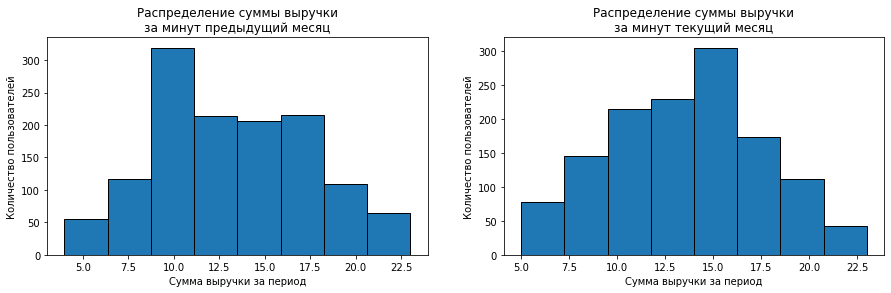


Представим все распределения на одном графике



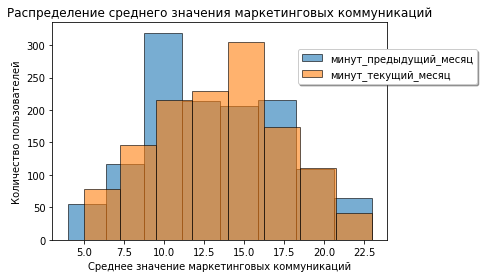

In [112]:
cols = ['минут_предыдущий_месяц', 'минут_текущий_месяц']

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
for i in range(0, len(cols)):
    time_modified[cols[i]].plot(kind='hist', edgecolor='black', bins=8, ax=axes[i])
    title = 'Распределение суммы выручки\nза ' + cols[i].replace('выручка_', '').replace('_', ' ')
    axes[i].set_title(title)
    axes[i].set_xlabel('Сумма выручки за период')
    axes[i].set_ylabel('Количество пользователей')
plt.show()

print()
print('Представим все распределения на одном графике')
print()

for i in range(0, len(cols)):
    time_modified[cols[i]].plot(kind='hist', edgecolor='black', bins=8, legend=True, alpha=0.6)
    plt.title('Распределение среднего значения маркетинговых коммуникаций')
    plt.xlabel('Среднее значение маркетинговых коммуникаций')
    plt.ylabel('Количество пользователей')

plt.legend(loc='upper center', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

In [113]:
for col in cols:
    my_describe(
        time_modified,
        col,
        desc=['describe']
    )


Ключевые характеристики распределения:
count    1300.00
mean       13.20
std         4.22
min         4.00
25%        10.00
50%        13.00
75%        16.00
max        23.00
Name: минут_предыдущий_месяц, dtype: object

Ключевые характеристики распределения:
count    1300.00
mean       13.47
std         3.93
min         5.00
25%        11.00
50%        13.00
75%        17.00
max        23.00
Name: минут_текущий_месяц, dtype: object


_**Вывод**_

В результате анализа выявлено, что для каждого из двух периодов распределение времени, проведенного на сайте, различно. Столбец таблицы с исходными данными был разделен на два столбца `минут_предыдущий_месяц` и `минут_текущий_месяц`. В дальнейшей работе будем использовать таблицу `time_modified`.

Выбросы не были обнаружены, очистка данных не потребовалась.

Выявлены ключевые характеристики распределения времени, проведенного на сайте, за предыдущий месяц:
* среднее и медиана близки - 13.20 и 13.00 минут;
* среднее значение выручки от 50% пользователей в диапазоне 10.00 - 16.00 минут;
* минимальное значение - 4.00 минут, максимальное - 23.00 минут.

Выявлены ключевые характеристики распределения времени, проведенного на сайте, за текущий месяц:
* среднее и медиана близки - 13.47 и 13.00 минут;
* среднее значение выручки от 50% пользователей в диапазоне 11.00 - 17.00 минут;
* минимальное значение - 5.00 минут, максимальное - 23.00 минут.

**Столбец `прибыль` таблицы `copy_add_money`**

В рассматриваемом столбце представлены значения количественного непрерывного параметра. Выведем основные характеристики для анализа с использованием созданной функции

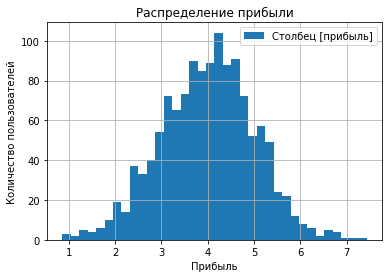


Ключевые характеристики распределения:
count    1300.00
mean        4.00
std         1.01
min         0.86
25%         3.30
50%         4.04
75%         4.67
max         7.43
Name: прибыль, dtype: object

Ключевые характеристики диграммы размаха:
IQR			1.37
Q1-1,5*IQR		1.24
MIN диаграммы размаха	1.24
Q3+1,5*IQR		6.72
MAX диаграммы размаха	6.72



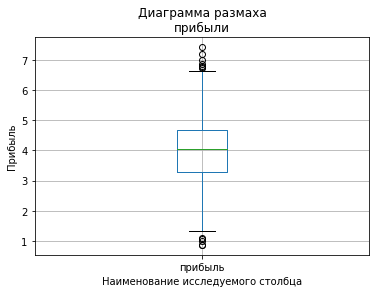

Ключевые характеристики выбросов:
Количество выбросов (вверх)	7
Доля выбросов (вверх)		0.54%
Количество выбросов (вниз)	5
Доля выбросов (вниз)		0.38%


In [114]:
my_describe(
    copy_add_money, 'прибыль',
    hist_desc=[
        'Распределение прибыли',
        'Прибыль',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nприбыли',
        'Наименование исследуемого столбца',
        'Прибыль'
    ]
)

В таблице `data_add_money` прибыль выражена в тысячах единиц, необходимо привести к единицам при работе с дополнительными данными.

In [115]:
copy_add_money['прибыль'] = copy_add_money['прибыль'] * 1000

Повторим анализ

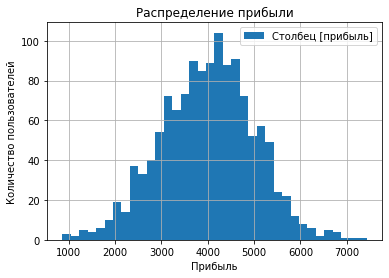


Ключевые характеристики распределения:
count    1300.00
mean     3996.63
std      1013.72
min       860.00
25%      3300.00
50%      4045.00
75%      4670.00
max      7430.00
Name: прибыль, dtype: object

Ключевые характеристики диграммы размаха:
IQR			1370.00
Q1-1,5*IQR		1245.00
MIN диаграммы размаха	1245.00
Q3+1,5*IQR		6725.00
MAX диаграммы размаха	6725.00



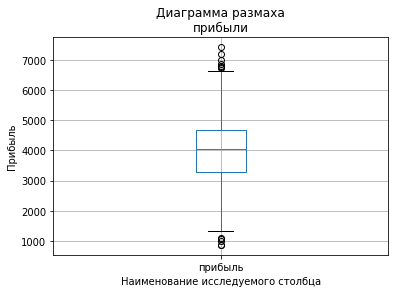

Ключевые характеристики выбросов:
Количество выбросов (вверх)	7
Доля выбросов (вверх)		0.54%
Количество выбросов (вниз)	5
Доля выбросов (вниз)		0.38%


In [116]:
my_describe(
    copy_add_money, 'прибыль',
    hist_desc=[
        'Распределение прибыли',
        'Прибыль',
        'Количество пользователей'
    ],
    box_desc=[
        'Диаграмма размаха\nприбыли',
        'Наименование исследуемого столбца',
        'Прибыль'
    ]
)

In [117]:
copy_add_money[copy_add_money['прибыль'] > 6720]

,id,прибыль
52,215400,6730.0
53,215401,7430.0
215,215563,6880.0
637,215985,6780.0
817,216165,7020.0
920,216268,6810.0
1026,216374,7210.0


In [118]:
change_depended_data(
    copy_add_money.query('прибыль > 6720'),
    'id',
    [copy_main, money_modified, time_modified]
)

Проверяем запись: 215400
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 215401
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 215563
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 215985
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 216165
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 216268
---> Проверяем таблицу [0] -> количество записей = 1
--

In [119]:
copy_add_money[copy_add_money['прибыль'] < 1240]

,id,прибыль
0,215348,980.0
182,215530,1060.0
774,216122,860.0
938,216286,1080.0
976,216324,860.0


In [120]:
change_depended_data(
    copy_add_money.query('прибыль < 1240'),
    'id',
    [copy_main, money_modified, time_modified]
)

Проверяем запись: 215348
---> Проверяем таблицу [0] -> количество записей = 0
---> Проверяем таблицу [1] -> количество записей = 0
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 215530
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 216122
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 216286
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1
Проверяем запись: 216324
---> Проверяем таблицу [0] -> количество записей = 1
---> Проверяем таблицу [1] -> количество записей = 1
---> Проверяем таблицу [2] -> количество записей = 1


В таблицах `copy_main`, `money_modified` и `time_modified` имеется указанные пользователи. Использовать дополнительную таблицу мы будем позднее. Не будем удалять выбросы, которые не выглядят, как аномалии.

Проверим нормальность распределения

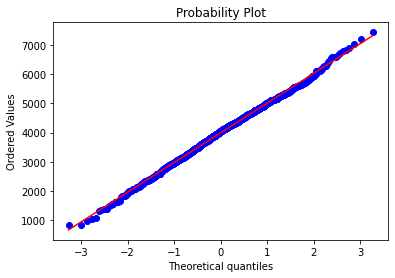

'p-value = 0.48865161270159563. Имеются основания говорить о нормальности распределения'

In [121]:
is_norm(copy_add_money['прибыль'])

Визуализируем очищенные данные

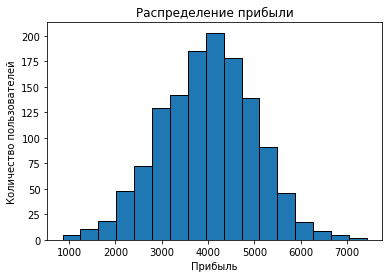

In [122]:
plt.hist(copy_add_money['прибыль'], edgecolor='black', bins=17)
plt.title('Распределение прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Количество пользователей')
plt.show()

In [123]:
my_describe(
    copy_add_money,
    'прибыль',
    desc=['describe']
)


Ключевые характеристики распределения:
count    1300.00
mean     3996.63
std      1013.72
min       860.00
25%      3300.00
50%      4045.00
75%      4670.00
max      7430.00
Name: прибыль, dtype: object


_**Вывод**_

В данных были обнаружены выбросы, однако не похожие на аномалии. В таблицах `copy_main`, `money_modified` и `time_modified` имеется указанные пользователи. Использовать дополнительную таблицу мы будем позднее. Не будем удалять выбросы, которые не выглядят, как аномалии.В связи с этим, выбросы не удалялись. Выявлены ключевые характеристики распределения прибыли:
* среднее и медиана близки - 3996.63 и 4045.00;
* среднее значение прибыли 50% пользователей в диапазоне 3300.00 - 4670.00;
* минимальное значение - 860.00, максимальное - 7430.00

Имеются основания говорить, что распределение параметра **нормально**.

### Вывод по разделу "Исследовательский анализ данных"

В результате проведения исследовательского анализа были выявлены следующие факторы, влияющие на достижение цели работы.

1. В результате исследования категориальных признаков выявлено:
    - признак "разрешить_сообщать" играет важную роль в дальнейшей работе после завершения разработки моделей машинного обучения. Если модель предскажет снижение пользовательской активности, но пользователь запретил присылать ему дополнительные предложения, то необходимо искать другие методы повышения его активности. Предлагается использовать указанный признак для первоначального обучения модели и затем оценить его значимость. **Вероятно, от него придется отказаться и выбрать только пользователей, которые разрешили присылать дополнительные предложения.**

    - Один из исследуемых столбов является целевым признаком для разработки модели машинного обучения - столбец `покупательская_активность`. Разрабатываемая модель машинного обучения должна прогнозировать снизится ли покупательская активность пользователя (подробности выбора в промежуточном выводе по подразделу I), а именно:
        - **класс 0 - "Прежний уровень" - для интернет-магазина хорошо;**
        - **класс 1 - "Снизилась" - для интернет-магазина плохо.**

            - При разработке машинного обучения будем особое внимание обращать на ошибку первого рода - ложно-отрицательную (FN):
                - если модель МО предскажет 0 ("прежний уровень"), но ошибется, то пользователь не получит дополнительного предложения и мы его потеряем.
                - если модель МО предскажет 1 ("снизилась"), но ошибется, то мы бы его не все равно не потеряли, но он получит дополнительное предложение. Вероятно, это может отпугнуть его (если пользователь не разрешил присылать ему дополнительные предложения), но сведений об этом не имеется.

    - Предлагается оценивать метрики _recall_ и _roc_auc_ (подробности выбора в промежуточном выводе по подразделу I). 

    - Для многоклассового признака в столбце `популярная_категория` также имеется дисбаланс, но считаем его менее важным, обработка не требуется.

2. В результате исследования количественных признаков таблицы `copy_main`:
    1. В данных были обнаружены выбросы, однако не похожие на аномалии, в столбце `маркет_актив_6_мес` (2.77%). В связи с этим, выбросы не удалялись. Среднее значение маркетинговых коммуникаций с пользователями составляет 4.25 ед. в месяц.
    2. В данных были обнаружены выбросы, однако не похожие на аномалии, в столбце `неоплаченные_продукты_штук_квартал` (1.04%). В связи с этим, выбросы не удалялись.
    2. В данных о доле акционных покупок пользователей выявлено, что пользователей можно разделить на два сегмента: часто покупающих по акции или редко. Трех пользователей, не участвующих в акциях было принято решение исключить из данных, поскольку для них может быть неактуальна рассылка персонизированных предложений. Создан новый признак в столбце сегменты_по_акциям. При разработке модели машинного обучения используем данный признак.
    3. Средние значения иных признаков:
        - среднее значение срока регистрации - 602.36 дней;
        - среднее количество маркетинговых коммуникаций в текущем месяце - 4 единицы;
        - средний срок регистрации пользователей - 602.36 дня;
        - больше всего пользователей за один визит просматривает 3 категории товаров;
        - больше всего пользователей имеют один неоплаченный товар в корзине;
        - больше всего пользователей столкнулось с 4 сбоями;
        - больше всего пользователей просматривает 6 страниц за один визит;
    4. Распределения дискретных случайных величин - распределение Пуассона.
    5. Имеются основания утверждать, что распределения непрерывных случайных велинин - не нормальны.

3. В результате исследования количественных признаков таблицы `copy_money`:    
    1. В результате анализа выявлено, что для каждого из трех периодов распределение выручки различно. Столбец таблицы с исходными данными был разделен на три столбца `выручка_препредыдущий_месяц`, `выручка_предыдущий_месяц` и `выручка_текущий_месяц`. В дальнейшей работе будем использовать таблицу money_modified.
    2. В данных были обнаружены выбросы, однако не похожие на аномалии (1.15%). В связи с этим, выбросы не удалялись. Минимальное количество пользователей с **нулевой** выручкой в каждом периоде и слишком высокой (более 100 000) были также удалены. При удалении выбросов также удалялись соответствущие записи из таблицы `copy_main`.
    3. Средние значения выручки:
        - среднее значение выручки в препредыдущем месяце - 4958.24 дней;
        - среднее значение выручки в предыдущем месяце - 5236.57 дней;
        - среднее значение выручки в текущем месяце - 4840.26 дней;
    5. Имеются основания утверждать, что распределения непрерывных случайных велинин - не нормальны.

3. В результате исследования количественных признаков таблицы `copy_time`: 
    1. В результате анализа выявлено, что для каждого из двух периодов распределение времени, проведенного на сайте, различно. Столбец таблицы с исходными данными был разделен на три столбца `минут_предыдущий_месяц` и `минут_текущий_месяц`. В дальнейшей работе будем использовать таблицу time_modified.
    2. Выбросы не были обнаружены, очистка данных не потребовалась.
    3. Средние значения времени, проведенного на сайте:
        - среднее значение времени, проведенного на сайте, в предыдущем месяце - 13.20 минут;
        - среднее значение времени, проведенного на сайте, в текущем месяце - 13.47 минут;
    4. Распределения дискретных случайных величин - распределение Пуассона.
    
3. В результате исследования количественных признаков таблицы `copy_add_money`: 
    1. В данных были обнаружены выбросы, однако не похожие на аномалии. В таблицах `copy_main`, `money_modified` и `time_modified` имеется указанные пользователи. Использовать дополнительную таблицу мы будем позднее. Не будем удалять выбросы, которые не выглядят, как аномалии. В связи с этим, выбросы не удалялись.
    2. Медиана прибыли составляет 4045.00 единиц.
    3. Имеются основания утверждать, что распределение непрерывной случайной велинины - нормально.

## Шаг 4. Объединение таблиц

В соотвествии с выводами предыдущих этапов для дальнейшей работы объединим таблицы `copy_main`, `money_modified` и `time_modified`. Ключевым столбцом является столбец `id` таблицы `copy_main`. Если в основной таблице нет данных о каких-либо пользователях, то мы не будем их учитывать.

Выведем размерности трех таблиц

In [124]:
copy_main.shape

(1296, 14)

In [125]:
copy_main.head(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,сегменты_по_акциям
1,215349,Снизилась,премиум,True,4.4,4,819,0.75,Товары для детей,4,4,2,5,Часто участвует
2,215350,Снизилась,стандарт,False,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,Мало участвует
3,215351,Снизилась,стандарт,True,3.2,5,896,0.99,Товары для детей,5,0,6,4,Часто участвует


In [126]:
money_modified.shape

(1296, 4)

In [127]:
money_modified.head(3)

,id,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4


In [128]:
time_modified.shape

(1300, 3)

In [129]:
time_modified.head(3)

,id,минут_текущий_месяц,минут_предыдущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13


In [130]:
good_data = copy_main.join(money_modified.set_index('id'), on='id', how='left')
good_data.shape

(1296, 17)

In [131]:
good_data = good_data.join(time_modified.set_index('id'), on='id', how='left')
good_data.shape

(1296, 19)

In [132]:
good_data.sample(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,сегменты_по_акциям,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
75,215423,Снизилась,стандарт,True,3.5,4,515,0.29,Косметика и аксесуары,1,4,4,1,Мало участвует,5586.5,4316.0,5682.7,10,10
347,215695,Снизилась,стандарт,True,4.3,4,324,0.14,Техника для красоты и здоровья,2,7,4,4,Мало участвует,5314.0,5160.0,5310.1,18,20
999,216347,Прежний уровень,премиум,True,5.4,3,491,0.15,Домашний текстиль,2,5,4,11,Мало участвует,4973.5,5653.0,4514.6,21,16
1161,216509,Прежний уровень,премиум,True,5.2,4,833,0.28,Товары для детей,5,1,8,15,Мало участвует,4808.0,4631.0,4784.6,13,15
158,215506,Снизилась,стандарт,False,3.0,5,600,0.31,Домашний текстиль,1,7,5,4,Мало участвует,5052.5,4238.0,5502.3,11,8


### Вывод по разделу "Объединение таблиц"

В результате работы объединены таблицы для начала разработки моделей машинного обучения. Количество записей в итоговой таблице - 1205, что составляет 92,7% от исходного объема.

## Шаг 5. Корреляционный анализ

В рамках корреляционного анализа признаков будем использовать коэффициент корреляции Спирмена, поскольку распределение количественных признаков в представленных данных не является нормальным.

Кроме того, используем коэффициент корреляции ϕk для оценки связи категориальных признаков.

Проверим наличие мультиколлинеарности между признаками. Мультикорреальность будем оценивать при коэффициенте корреляции от 0.9 до 1 (очень высокая связь по шкале Чеддока).

Для анализа применен созданные функции.

Проведем корреляционный анализ входных и целевых признаков по двум группам, сформированным по целевому признаку:

Целевой признак `покупательская_активность` - категориальный.
Входные признаки:
- `тип_сервиса` - категориальный;
- `разрешить_сообщать` - категориальный;
- `маркет_актив_6_мес` - количественный;
- `маркет_актив_тек_мес` - количественный;
- `длительность` - количественный;
- `акционные_покупки` - количественный;
- `популярная_категория` - категориальный;
- `средний_просмотр_категорий_за_визит` - количественный;
- `неоплаченные_продукты_штук_квартал` - количественный;
- `ошибка_сервиса` - количественный;
- `страниц_за_визит` - количественный;
- `сегменты_по_акциям` - категориальный;
- `выручка_препредыдущий_месяц` - количественный;
- `выручка_текущий_месяц` - количественный;
- `выручка_предыдущий_месяц` - количественный;
- `минут_текущий_месяц` - количественный;
- `минут_предыдущий_месяц` - количественный.

Построим матрицы корреляции между количественными и категориальными признаками.

In [133]:
corr_num_columns = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц',
    'выручка_предыдущий_месяц',
    'минут_текущий_месяц',
    'минут_предыдущий_месяц',
]
corr_cat_columns = [
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория',
    'сегменты_по_акциям'
]
target = 'покупательская_активность'

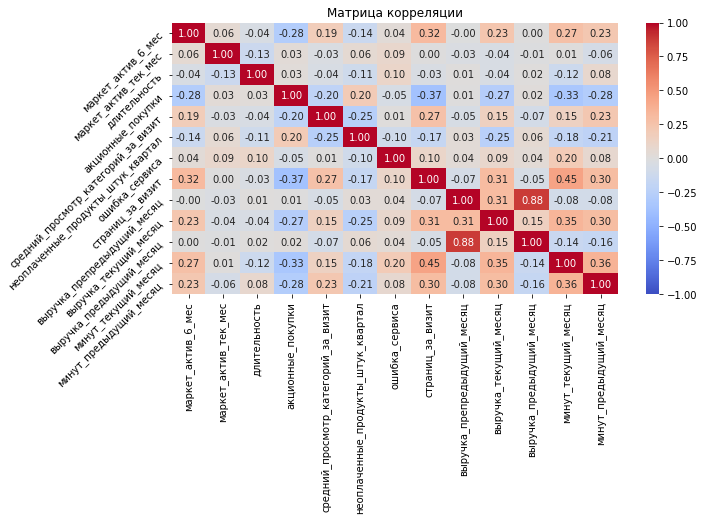

In [134]:
corr_matrix(good_data, corr_num_columns, 'spearman', target=target)

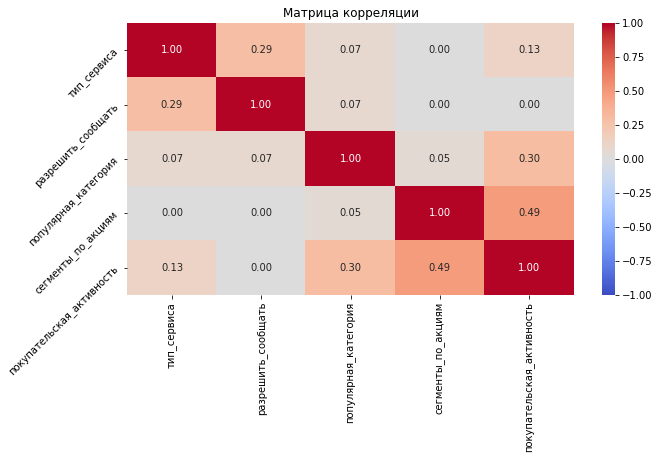

In [135]:
corr_matrix(good_data, corr_cat_columns, 'phik', target=target)

Сильной линейной связи (коэффициент корреляции от 0.9 и выше) между входными признаками (мультиколлениарности) не обнаружено.

Рассмотрим влияние входных признаков на целевой признак

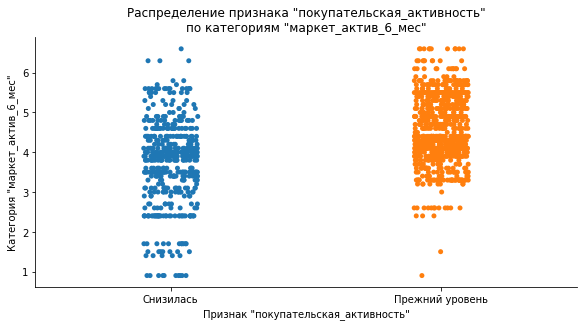

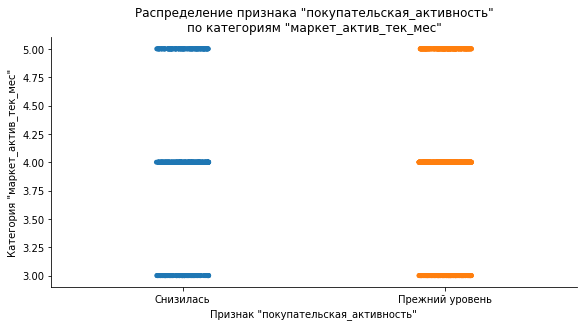

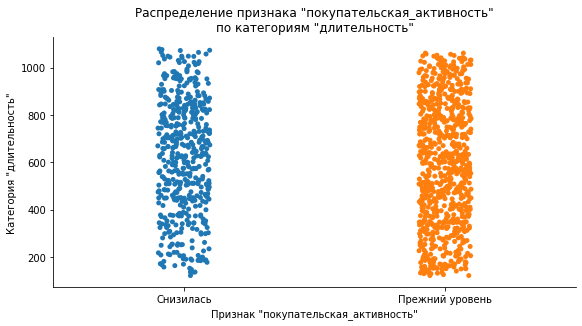

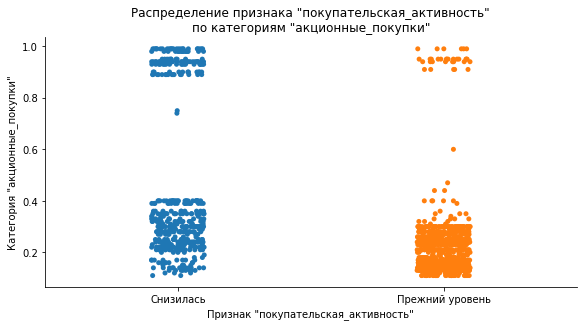

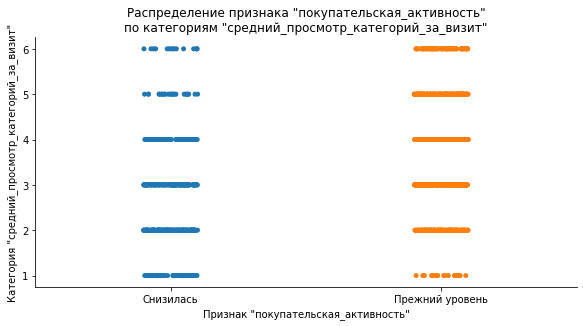

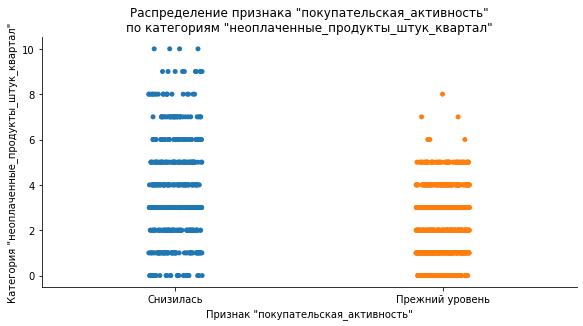

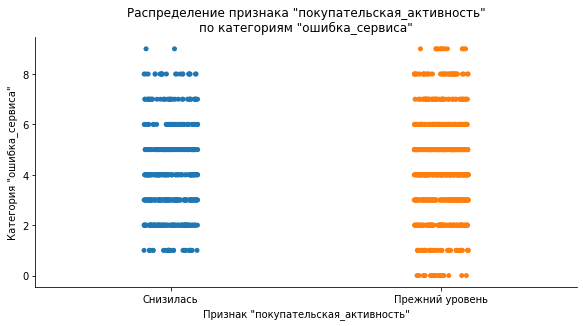

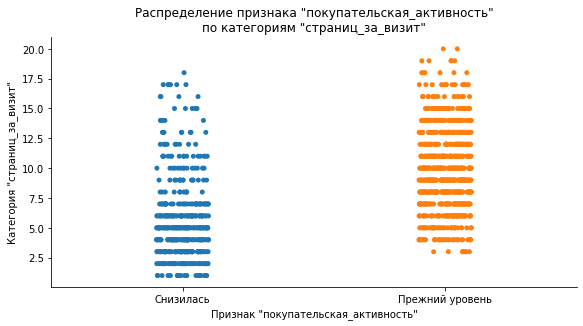

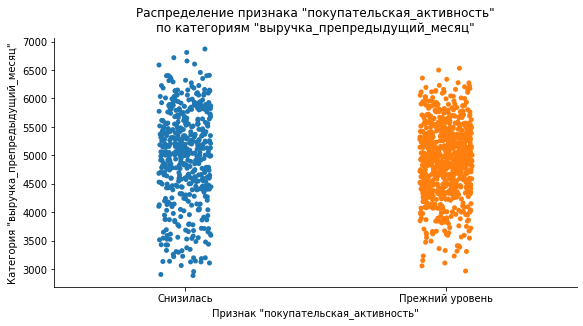

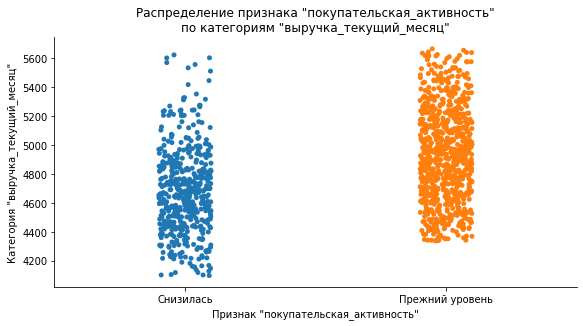

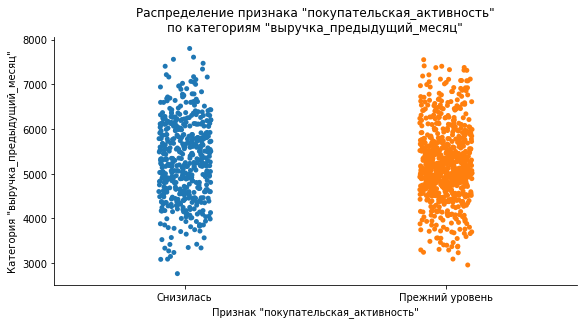

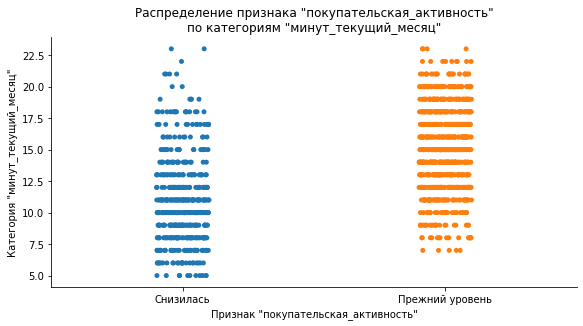

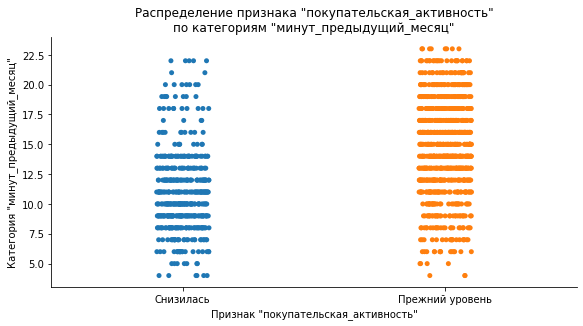

In [136]:
for item in corr_num_columns:
    numcat_scatter(good_data, 'cat', cols=[target,item])

Сильного однозначного влияния входных признаков на целевой признак не выявлено.

### Вывод по разделу "Корреляционный анализ"

В результате проведения корреляционного анализа выявлены следующие факторы, влияющие на результат работы.

1. Сильной линейной связи (коэффициент корреляции от 0.9 и выше) между входными признаками (мультиколлениарности) не обнаружено.
2. Линейной связи между входными и целевым признаком не обнаружено. Сильного однозначного влияния входных признаков на целевой признак не выявлено

## Шаг 6. Поиск лучшей модели машинного обучения (с использованием пайплайнов и подбора гиперпараментров)

В рамках работы осуществим поиск лучшей модели машинного обучения из следующих: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC()

Разделим данные на тренировочную и тестовую выборки. Также удалим столбец `id` (путем преобразования его в индекс), так как с ним получим утечку целевого признака. Раз в данных был обнаружен дисбаланс классов по одному из признаков выполним стратификацию по целевому признаку. Отобразим результаты разделения.

In [137]:
good_data = good_data.set_index('id')
good_data

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,сегменты_по_акциям,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,True,4.4,4,819,0.75,Товары для детей,4,4,2,5,Часто участвует,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,False,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,Мало участвует,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,True,3.2,5,896,0.99,Товары для детей,5,0,6,4,Часто участвует,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,False,5.1,3,1064,0.94,Товары для детей,3,2,3,2,Часто участвует,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,True,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,Мало участвует,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,True,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,Мало участвует,3664.0,4704.0,4741.7,14,7
216644,Прежний уровень,стандарт,False,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,Мало участвует,4729.0,5299.0,5353.0,12,11
216645,Прежний уровень,стандарт,True,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,Мало участвует,5160.0,5334.0,5139.2,12,18


In [138]:
if is_num_for_target:
    good_data['покупательская_активность'] = (
        good_data['покупательская_активность']
        .apply(lambda x: 1 if x == 'Снизилась' else 0)
    )
good_data

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,сегменты_по_акциям,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,True,4.4,4,819,0.75,Товары для детей,4,4,2,5,Часто участвует,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,False,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,Мало участвует,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,True,3.2,5,896,0.99,Товары для детей,5,0,6,4,Часто участвует,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,False,5.1,3,1064,0.94,Товары для детей,3,2,3,2,Часто участвует,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,True,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,Мало участвует,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,True,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,Мало участвует,3664.0,4704.0,4741.7,14,7
216644,Прежний уровень,стандарт,False,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,Мало участвует,4729.0,5299.0,5353.0,12,11
216645,Прежний уровень,стандарт,True,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,Мало участвует,5160.0,5334.0,5139.2,12,18


In [139]:
X = good_data.drop([target], axis=1)
y = good_data[target]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = good_data[target]
)
X_train.shape, X_test.shape

((972, 17), (324, 17))

Создадим пайплайн для поиска лучшей модели с использованием ColumnTransformer

In [140]:
# определим списки с признаками для обработки ohe и scalers
ohe_columns = corr_cat_columns
num_columns = corr_num_columns

# создадим пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# создадим общий пайплайн для подготовки данных - ohe_pipe и скэйлеры для количественных столбцов
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', None, num_columns)
    ], 
    remainder='passthrough'
)

# создадим итоговый пайплайн: подготовка данных 
# и неопределенная модель, поскольку будем подбирать 
# гиперпараметры для различных моделей
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
)

In [141]:
# создаём функцию для подсчёта метрики TPR
def get_true_positive_rate(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    return conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])

# считаем метрику TPR через make_scorer()
true_positive_rate_score = make_scorer(
    get_true_positive_rate,
    greater_is_better=True
)

# создаем словарь метрик для подбора лучшей модели
if is_num_for_target:
    scoring = {
        'f1_score': 'f1',
        'true_positive_rate': true_positive_rate_score
    }
else:
    scoring = {
        'roc_auc_score': 'roc_auc',
        'true_positive_rate': true_positive_rate_score
    }

In [142]:
# создадим сетку параметров для подбора лучшей модели
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
        )],
        'models__C': range(1, 5), 
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear'],        
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            kernel='linear',
            probability=True
        )],
        'models__C': range(1, 5),
        'models__class_weight' : ['balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

In [143]:
# создадим экземпляр класса поиска лучшей модели по сетке
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    refit='true_positive_rate'
)

In [144]:
# Обучим модели
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['тип_сервиса',
                                                                          'разрешить_сообщать',
                                                                          'популярная_категория',
                                                                          'сегменты_по_акциям']),
                                                                        ('num',
                                                                         None,
                                                                         ['маркет_актив_6_мес',
                                                                          'маркет_актив...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]},
                         {'models': [SVC(class_weight='balanced',
                                         kernel='linear', probability=True,
                                         random_state=42)],
                          'models__C': range(1, 5),
                          'models__class_weight': ['balanced'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler()]}],
             refit='true_positive_rate',
             scoring={'roc_auc_score': 'roc_auc',
                      'true_positive_rate': make_scorer(get_true_positive_rate)})

In [145]:
print('Метрика TPR лучшей модели на тренировочной выборке:', grid_search.best_score_)

Метрика TPR лучшей модели на тренировочной выборке: 0.768831620474813


In [146]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория',
                                                   'сегменты_по_акциям']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',


In [147]:
# Используем лучшую модель для прогнозирования на тестовой выборке
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:,1]

Представим результаты работы лучшей модели в виде удобной таблицы

In [148]:
result = pd.DataFrame(
    {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob
    }).reset_index()
result[(result['y_prob'] < 0.46) & (result['y_prob'] > 0.43)].sort_values(by='y_prob')

,id,y_test,y_pred,y_prob
50,216256,Прежний уровень,Прежний уровень,0.431938
242,216321,Прежний уровень,Прежний уровень,0.435975
185,215984,Прежний уровень,Прежний уровень,0.441911
300,216627,Прежний уровень,Прежний уровень,0.450928
115,215752,Прежний уровень,Снизилась,0.455046
64,215906,Снизилась,Снизилась,0.458917


Видим ошибки второго рода - предсказан класс 0 ("Прежний уровень") для пользователя с классом 1 ("Снизилась"). Это критическая ошибка. Мы потеряем такого пользователя. Визуализируем ошибки.

Обратим внимание, что лучшая модель выбрана с порогом классификации около 0,452987 за счет гиперпараметра модели SVC: class_weight='balanced'.

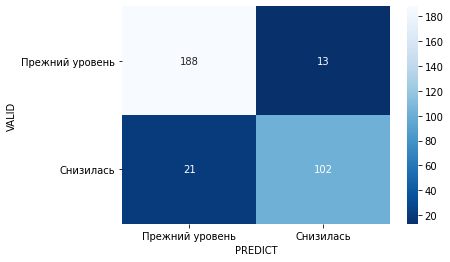

In [149]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r',
            xticklabels=['Прежний уровень','Снизилась'],
            yticklabels=['Прежний уровень','Снизилась'])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set(xlabel='PREDICT', ylabel='VALID')
plt.show()

На тестовой выборке мы получили FN=21 предсказаний. Обсудим с руководством необходимость их минимизации.

Проверим метрики на тестовой выборке

Метрика TPR лучшей модели на тестовой выборке: 0.8292682926829268
Метрика RECALL лучшей модели на тестовой выборке: 0.8292682926829268
Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9155037819034907
ROC-кривая на тестовой выборке:


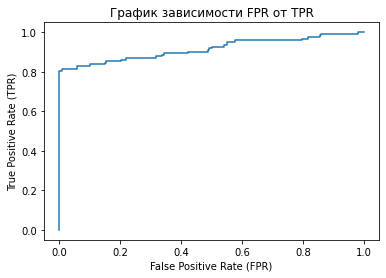

In [150]:
if is_num_for_target:
    print('Метрика TPR лучшей модели на тестовой выборке:', get_true_positive_rate(y_test, y_pred))
    print('Метрика RECALL лучшей модели на тестовой выборке:', recall_score(y_test, y_pred))
    print('Метрика F1-мера лучшей модели на тестовой выборке:', recall_score(y_test, y_pred))
else:
    print('Метрика TPR лучшей модели на тестовой выборке:', get_true_positive_rate(y_test, y_pred))
    print('Метрика RECALL лучшей модели на тестовой выборке:', recall_score(y_test, y_pred, pos_label='Снизилась'))
    print('Метрика ROC-AUC лучшей модели на тестовой выборке:', roc_auc_score(y_test, y_prob))
    print('ROC-кривая на тестовой выборке:')

    fpr, tpr, threshold = roc_curve(y_test, y_prob, pos_label='Снизилась')

    # постройте график зависимости FPR от TPR
    plt.plot(fpr, tpr)
    plt.title("График зависимости FPR от TPR")
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.show()

В 13% случаев модель неверно предсказывает снижение активности пользователей. Обсудим с руководством качество модели.

Определим полные параметры лучшей модели для ее обучения и анализа признаков

In [151]:
if is_num_for_target:
    gs_results = pd.DataFrame(
        grid_search.cv_results_
    ).sort_values(
        by=['rank_test_true_positive_rate', 'rank_test_f1_score']
    )[[
        'params',
        'mean_test_f1_score',
        'rank_test_f1_score',
        'mean_test_true_positive_rate',
        'rank_test_true_positive_rate'
    ]]
else:
    gs_results = pd.DataFrame(
        grid_search.cv_results_
    ).sort_values(
        by=['rank_test_true_positive_rate', 'rank_test_roc_auc_score']
    )[[
        'params',
        'mean_test_roc_auc_score',
        'rank_test_roc_auc_score',
        'mean_test_true_positive_rate',
        'rank_test_true_positive_rate'
    ]]
gs_results.head(4)

,params,mean_test_roc_auc_score,rank_test_roc_auc_score,mean_test_true_positive_rate,rank_test_true_positive_rate
41,"{'models': SVC(class_weight='balanced', kernel...",0.891310,17,0.768832,1
43,"{'models': SVC(class_weight='balanced', kernel...",0.891249,18,0.768832,1
45,"{'models': SVC(class_weight='balanced', kernel...",0.890739,19,0.768832,1
47,"{'models': SVC(class_weight='balanced', kernel...",0.890670,20,0.768832,1


Отметим, что результат с максимальной TPR даёт менее качественную классификацию (по метрике ROC-AUC). 

Решение, какую модель использовать, теперь за руководством. Если важнее правильно находить пользователей со сниженной активностью — тогда выбор за моделью с лучшей TPR. Если важнее качественно классифицировать данные — стоит выбрать модель с высокой ROC-AUC.

Отметим, что результат с максимальной TPR даёт максимальную классификацию по метрике F1-мера. 

In [152]:
gs_results.loc[41,'params']

{'models': SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42),
 'models__C': 1,
 'models__class_weight': 'balanced',
 'preprocessor__num': MinMaxScaler()}

### Вывод по разделу "Поиск лучшей модели машинного обучения"

В результате поиска лучшей модели достигнуты следующие результаты:

1. Сформирован pipeline для поиска лучшей модели с использованием подбора гиперпараментров по сетке для четырех моделей KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC().
2. В сетку гиперпараментров для каждой модели подобраны несколько гиперпараметров, данные маштабированы как минимум двумя методами, отдельно обработаны категориальные и количественные признаки.
3. На основании выбранных метрик (TPR и ROC-AUC) выбран подбор гиперпараментров с мультискорингом.
4. Метрика TPR лучшей модели на тренировочной выборке составила 0.769. Лучшей признана модель SVC(). При этом, метрика ROC-AUC ниже максимальной. Если важнее правильно находить пользователей со сниженной активностью — тогда выбор за моделью с лучшей TPR. Если важнее качественно классифицировать данные — стоит выбрать модель с высокой ROC-AUC.
5. Метрика TPR (RECALL) лучшей модели на тестовой выборке: 0.829, метрика ROC-AUC лучшей модели на тестовой выборке: 0.915.

## Шаг 7. Анализ важности признаков

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP

In [153]:
best_model = SVC(C=1, class_weight='balanced', kernel='linear',
            probability=True, random_state=RANDOM_STATE)

In [154]:
best_data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [155]:
# Трансформируем данные для обучения модели
X_train_best_trasform = best_data_preprocessor.fit_transform(X_train)
X_test_best_trasform = best_data_preprocessor.transform(X_test)

# Создадим датафрейм на основе трансформированных данных
X_train_best_trasform = pd.DataFrame(X_train_best_trasform, columns=best_data_preprocessor.get_feature_names_out())
X_test_best_trasform = pd.DataFrame(X_test_best_trasform, columns=best_data_preprocessor.get_feature_names_out())

# Обучим модель на трансформированных данных
best_model.fit(X_train_best_trasform, y_train)

SVC(C=1, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)

In [156]:
# Проведем предсказание лучшей модели на тестовой выборке
y_pred_best = best_model.predict(X_test_best_trasform)

Проверим, что обучена верная модель. Проверим метрику TPR на тестовых данных

In [157]:
get_true_positive_rate(y_test, y_pred_best)

0.8211382113821138

In [158]:
columns = list(X_train_best_trasform.columns)
all_variants = list(combinations(columns, 2))

Совпадает с результатами выше. Начнем анализ важности признаков.

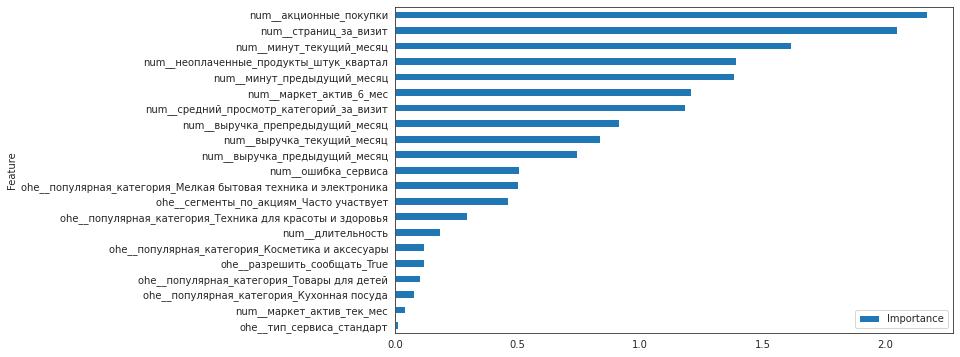

In [159]:
coefficients = best_model.coef_[0]
feature_importance_coef = pd.DataFrame(
    {
        'Feature': best_data_preprocessor.get_feature_names_out(),
        'Importance': np.abs(coefficients)
    }
)
feature_importance_coef = feature_importance_coef.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance_coef.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Со значительным отрывом лидируют популярная категория "акционные покупки" и "страниц_за_визит". Далее по убыванию новый признак "минут_текущий_месяц", "неоплаченные_продукты_штук_квартал", "минут_предыдущий_месяц" и другие.

Самые неважные признаки - "длительность", "ошибка сервиса" и "разрешить сообщать".

**А также, очень интерсно, не важен признак "маркет актив тек мес" - т.е. количество маркетинговых взаимодействий в текущем месяце. Вероятно, это может быть связано с тем, что текущий месяц еще не закончился, а мы уже имеем сведения об активности пользователя. Фактически, нет смысла использовать данные за текущий месяц для обучения и предсказания активности ни в текущем месяце, ни в следующем.** Однако, количество минут на сайте, выручка за текущий месяц имеют среднее влияние.

*Проверим важность признаков иначе - с использованием permutation importance для выбранной метрики (TPR).*

In [160]:
perm_importance = permutation_importance(best_model, X_test_best_trasform, y_test, scoring=true_positive_rate_score)

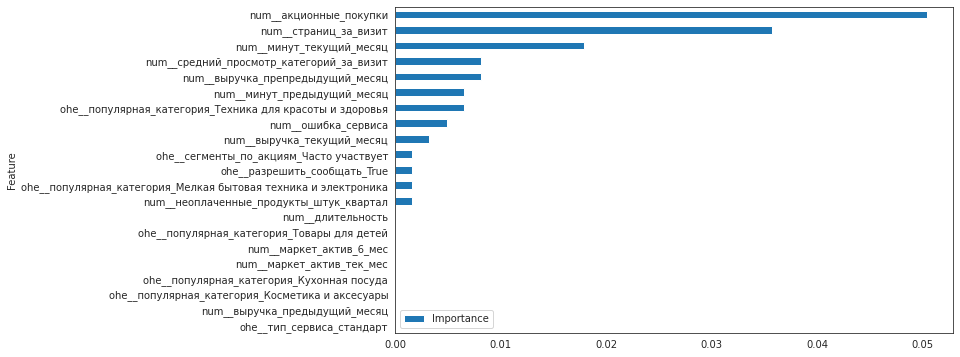

In [161]:
feature_importance_pm = pd.DataFrame(
    {
        'Feature': best_data_preprocessor.get_feature_names_out(),
        'Importance': np.abs(perm_importance['importances_mean'])
    }
)
feature_importance_pm = feature_importance_pm.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance_pm.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

Перемешивание значений выявило тех же фаворитов: "акционные_покупки" и "страниц_за_визит".

Все признаки текущего месяца: минуты, выручка; и, конечно, "маркет_актив_тек_мес" имеют невысокую важность. Последниие 5 признаков имеет нулевую важность. Проверим еще одним способом.

*Проведем анализ SHAP-значений.*

In [162]:
explainer = shap.LinearExplainer(best_model, X_test_best_trasform)
shap_values = explainer(X_test_best_trasform)

Построим график общей значимости признаков. Столбчатая диаграмма отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. 

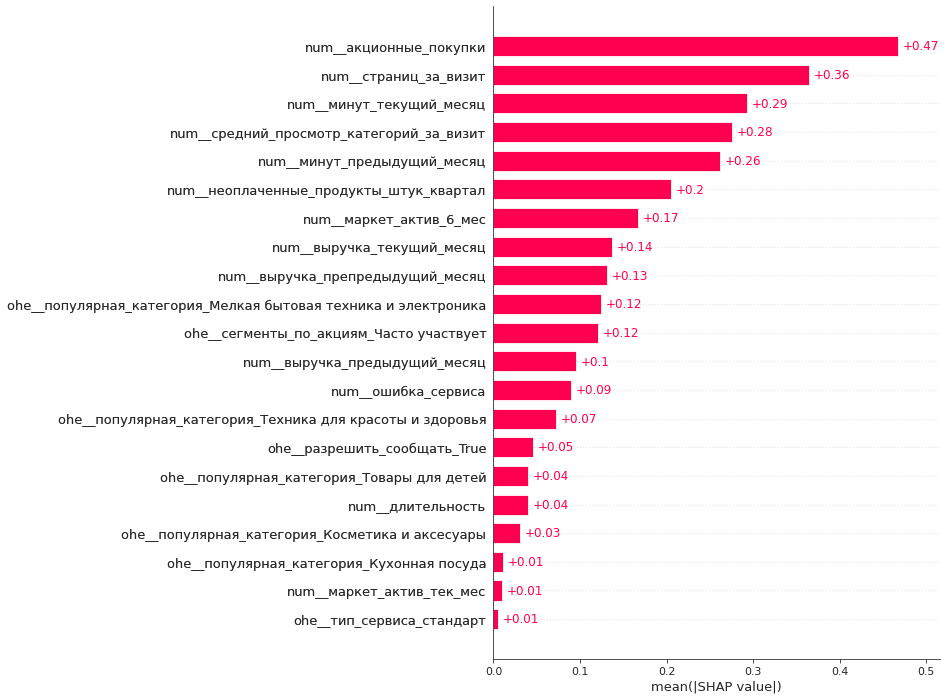

In [163]:
shap.plots.bar(shap_values, max_display=None) 

Лидирует снова признак "акционные покупки", а также признаки "страниц за визит", "минут текущий месяц", "средний просмотр категорий за визит".

"выручка_текущий_месяц" также в верхней части. Но, великолепный признак "маркет_актив_тек_мес" по-прежнему в аутсайдерах.

*Посмотрим, как признаки влияют на каждое предсказание модели*

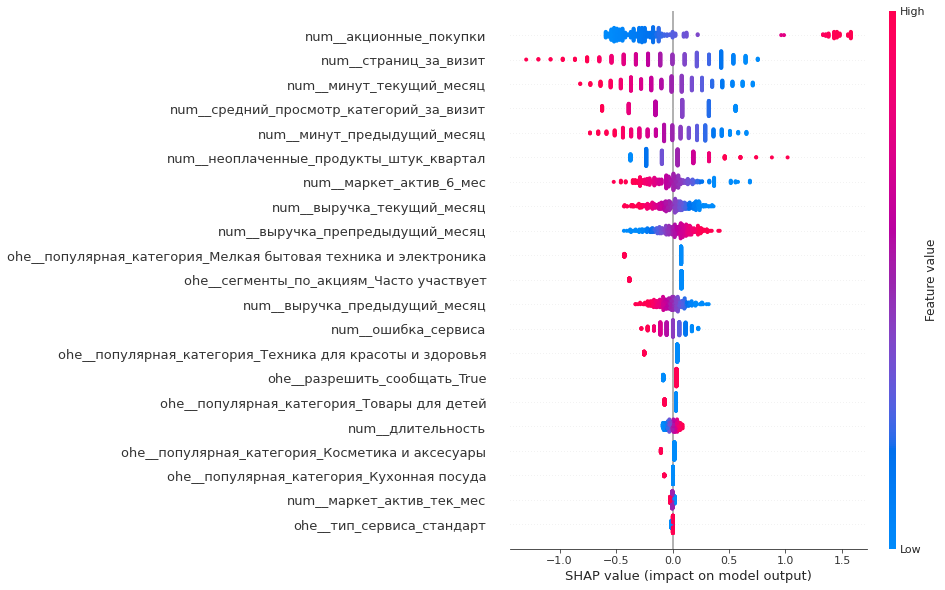

In [164]:
shap.plots.beeswarm(shap_values, max_display=None)

В соответствии с визуализацией влияния признаков на классификацию можно сделать следующие выводы:
- самый важный признак - доля акционных покупок: чем больше, тем вероятнее снижение активности;
- активность взаимодействия с сайтом (количество просмотренных страниц за визит, средний просмотр категорий за визит, длительность времени, проведенного на сайте за период): чем больше, тем менее вероятно снижение активности;
- количество неоплаченных продуктов: чем больше, тем вероятнее снижение активности.
- выручка текущий месяц: чем меньше, тем вероятнее снижение активности.

Интерсным фактом является противоположность влияния признаков "выручка_предыдущий_месяц" и "выручка_препредыдущий_месяц".

Самыми неважными признаками являются:
- количество маркетинговых коммуникаций в текущем месяце - в связи с тем, что мы обучали модель на результатах активности за текущий месяц, вполне логично, что данный признак не может влиять на целевой признак. Для предсказаний на будущий период указанный признак окажется ретроспективным.
- разрешение на дополнительные предложения - на активность не влияет. Повлияет только на рассылку предложений - увеличить активность пользователей, которые запретили дополнительные предложения, с помошью этих предложений не удастся.
- тип сервиса - на активность влияет очень слабо. Снижений активности наблюдается для пользователей с различным сервисом.

Популярные категории, длительноть регистрации и количество ошибок на сайте влияют слабо.

Проверим вклад каждого признака в FN результаты - предсказанные классы 0 вместо реальных классов 1.

In [165]:
result.query('y_test == "Снизилась" and y_pred == "Прежний уровень"').head(5)

,id,y_test,y_pred,y_prob
24,215907,Снизилась,Прежний уровень,0.120350
27,215938,Снизилась,Прежний уровень,0.045412
67,215746,Снизилась,Прежний уровень,0.411006
77,215802,Снизилась,Прежний уровень,0.099836
83,215810,Снизилась,Прежний уровень,0.141882


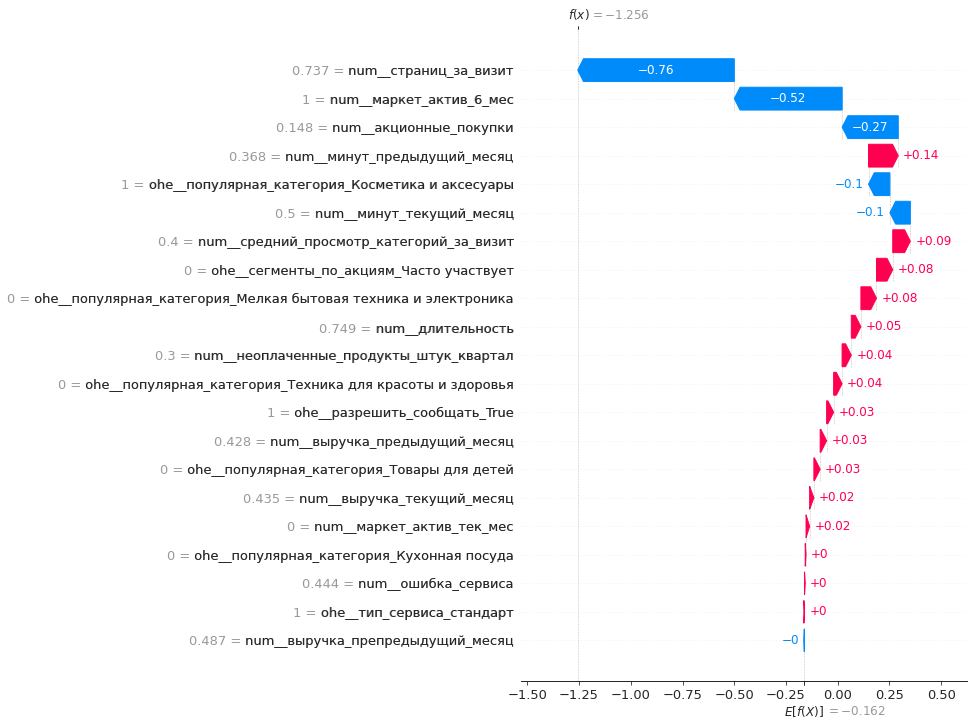

In [166]:
shap.plots.waterfall(shap_values[24], max_display=21) 

Сильнее всего на классификацию рассмотренного наблюдения влияют признаки "страниц за визит", "маркет_актив_6_мес" и "акционны покупки": они «перетягивают» предсказание в сторону класса 0. Т.е. длительность активности на сайте, макректинг за полгода и количество акционных покупок.

### Вывод по разделу "Анализ важности признаков"

В соответствии с визуализацией влияния признаков на классификацию можно сделать следующие выводы:
- самый важный признак - доля акционных покупок: чем больше, тем вероятнее снижение активности;
- активность взаимодействия с сайтом (количество просмотренных страниц за визит, средний просмотр категорий за визит, длительность времени, проведенного на сайте за период): чем больше, тем менее вероятно снижение активности;
- количество неоплаченных продуктов: чем больше, тем вероятнее снижение активности.
- выручка текущий месяц: чем меньше, тем вероятнее снижение активности.

Маловажными признаками являются:
- количество маркетинговых коммуникаций в текущем месяце - в связи с тем, что мы обучали модель на результатах активности за текущий месяц, вполне логично, что данный признак не может влиять на целевой признак. Для предсказаний на будущий период указанный признак окажется ретроспективным.
- разрешение на дополнительные предложения - на активность не влияет. Повлияет только на рассылку предложений - увеличить активность пользователей, которые запретили дополнительные предложения, с помошью этих предложений не удастся.
- тип сервиса - на активность влияет очень слабо. Снижений активности наблюдается для пользователей с различным сервисом.

Популярные категории, длительноть регистрации и количество ошибок на сайте влияют слабо.

Из выводов следуют несколько гипотез:
Если снижается активность постоянных клиентов при большом количестве акционных покупок надо проработать условия для каких-то дополнительных льгот, чтобы их удерживать.
Надо повышать длительность взаимодействия пользователей с сайтом, например, увеличить его юзабилити, добавить небольшие подарки на случайных страницах.
Необходимо сколнять пользователей к оплате добавленных товаров в корзину, например, бесплатной доставкой, персональными предложениями, влияющими на принятие решения пользователя об оплате товаров.

**Ответ на вопрос: "Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений?"**

_Наблюдения важности признаком можно использовать при моделировании для упрощения модели (исключив неважные признаки) и для усложнения модели (добавив новые признаки на основе важных). И упрощение модели и ее усложение могут дать более высокие показатели качества работы модели._

_Кроме того, определение важности признаков повышает интерпретируемось моделей и позволяет принимать понятные и взвешенные бизнес-решения._


## Шаг 8. Сегментация покупателей

Выполним сегментацию покупателей по критерию, определенному руководством, выделим сегмент покупателей, проанализируем его и попробуем предложить, как увеличить его покупательскую активность. 

Руководитель отдела поставил задачу выделить группы клиентов:
- группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности;
- группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом;
- группа клиентов, которые покупают товары из категории «Товары для себя»;
- группа клиентов, которые покупают товары из категории «Товары для детей»;
- группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Добавим к результатам моделирования (с указанием вероятности снижения активности y_prob) исходные данные и сведения о прибыльности.

In [167]:
result.shape

(324, 4)

In [168]:
X_test.shape

(324, 17)

In [169]:
copy_add_money.shape

(1300, 2)

In [170]:
new_data = result.join(X_test, on='id', how='left')
new_data.shape

(324, 21)

In [171]:
# Переименуем столбцы для удобства работы с результатами моделирования
new_data = new_data.rename(
    columns = {
        'y_pred': 'покупательская_активность',
        'y_prob': 'вероятность_снижения',
    }
).drop('y_test', axis=1)

In [172]:
new_data = new_data.join(copy_add_money.set_index('id'), on='id', how='left')
new_data.shape

(324, 21)

In [173]:
new_data.sample(5)

,id,покупательская_активность,вероятность_снижения,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,сегменты_по_акциям,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль
72,215378,Снизилась,0.745977,стандарт,True,1.7,3,488,0.39,Техника для красоты и здоровья,...,1,4,3,Мало участвует,3543.0,4302.0,4364.6,12,8,3030.0
285,216119,Прежний уровень,0.193751,премиум,True,4.1,3,208,0.13,Косметика и аксесуары,...,2,1,10,Мало участвует,5004.0,5154.0,5004.0,12,8,4930.0
230,215505,Снизилась,0.922345,стандарт,True,4.4,4,254,0.31,Товары для детей,...,3,5,3,Мало участвует,3951.0,4698.0,3982.2,7,7,6550.0
317,215458,Снизилась,0.463522,стандарт,True,4.4,3,851,0.32,Косметика и аксесуары,...,3,4,6,Мало участвует,5772.5,4925.0,6187.2,14,15,2980.0
297,215828,Прежний уровень,0.098433,стандарт,True,5.3,4,191,0.30,Товары для детей,...,4,3,16,Мало участвует,4405.0,5240.0,5259.1,10,14,3300.0


Сформируем новые категории для сегментирования.

In [174]:
new_data['популярная_категория'].unique()

array(['Техника для красоты и здоровья', 'Товары для детей',
       'Домашний текстиль', 'Мелкая бытовая техника и электроника',
       'Косметика и аксесуары', 'Кухонная посуда'], dtype=object)

Выделим три группы товаров по назначению - Товары для детей, Товары для дома, Товары для себя.

In [175]:
new_data['группа_товаров_по_назначению'] = new_data['популярная_категория'].apply(create_groups_categories)
new_data[
    [
        'id',
        'популярная_категория',
        'группа_товаров_по_назначению',
        'прибыль'
    ]
].head(5)

,id,популярная_категория,группа_товаров_по_назначению,прибыль
0,216161,Техника для красоты и здоровья,Товары для себя,4690.0
1,215654,Товары для детей,Товары для детей,2750.0
2,216307,Домашний текстиль,Товары для дома,3160.0
3,215501,Домашний текстиль,Товары для дома,3740.0
4,215934,Мелкая бытовая техника и электроника,Товары для дома,4400.0


In [176]:
my_describe(new_data, 'прибыль', desc=['describe'])


Ключевые характеристики распределения:
count     324.00
mean     3907.44
std       997.42
min       860.00
25%      3242.50
50%      3980.00
75%      4585.00
max      6880.00
Name: прибыль, dtype: object


Выделим две группы пользователей по прибыльности - высокая и низкая относительно среднего значения.

In [177]:
new_data['прибыльность'] = new_data['прибыль'].apply(lambda x: 'высокая' if x > 4026.46 else 'низкая')
new_data[
    [
        'id',
        'прибыльность',
        'прибыль'
    ]
].head(5)

,id,прибыльность,прибыль
0,216161,высокая,4690.0
1,215654,низкая,2750.0
2,216307,низкая,3160.0
3,215501,низкая,3740.0
4,215934,высокая,4400.0


Выделим три группы товаров по типу - Товары с длинным жизненным циклом, Товары частой замены.

In [178]:
new_data['группа_товаров_по_типу'] = new_data['популярная_категория'].apply(create_groups_types_categories)
new_data[
    [
        'id',
        'популярная_категория',
        'группа_товаров_по_типу',
        'прибыль'
    ]
].head(5)

,id,популярная_категория,группа_товаров_по_типу,прибыль
0,216161,Техника для красоты и здоровья,Товары с длинным жизненным циклом,4690.0
1,215654,Товары для детей,Товары частой замены,2750.0
2,216307,Домашний текстиль,Товары частой замены,3160.0
3,215501,Домашний текстиль,Товары частой замены,3740.0
4,215934,Мелкая бытовая техника и электроника,Товары с длинным жизненным циклом,4400.0


Выделим две группы пользователей по вероятности снижения активности - высокая и низкая относительно порога классификации выбранной модели.

In [179]:
new_data['категория_вероятности'] = new_data['вероятность_снижения'].apply(lambda x: 'высокая' if x > 0.427825 else 'низкая')
new_data[
    [
        'id',
        'вероятность_снижения',
        'категория_вероятности'
    ]
].head(5)

,id,вероятность_снижения,категория_вероятности
0,216161,0.017672,низкая
1,215654,0.981658,высокая
2,216307,0.093206,низкая
3,215501,0.835355,высокая
4,215934,0.581505,высокая


**Сформируем группы (сегменты) пользователей**

Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности

In [180]:
new_data.pivot_table(index=['категория_вероятности', 'сегменты_по_акциям'], values=['id'], aggfunc='count')

id
категория_вероятности сегменты_по_акциям     
высокая               Мало участвует       80
                      Часто участвует      39
низкая                Мало участвует      199
                      Часто участвует       6

In [181]:
group1 = new_data.query('категория_вероятности == "высокая" and сегменты_по_акциям == "Часто участвует"')
group1.head(3)

,id,покупательская_активность,вероятность_снижения,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль,группа_товаров_по_назначению,прибыльность,группа_товаров_по_типу,категория_вероятности
1,215654,Снизилась,0.981658,премиум,False,1.4,4,684,0.94,Товары для детей,...,3548.0,4656.0,4170.7,11,9,2750.0,Товары для детей,низкая,Товары частой замены,высокая
4,215934,Снизилась,0.581505,стандарт,False,5.5,4,147,0.99,Мелкая бытовая техника и электроника,...,5090.0,4451.0,5773.8,15,18,4400.0,Товары для дома,высокая,Товары с длинным жизненным циклом,высокая
10,215844,Снизилась,0.778965,премиум,True,4.3,4,1041,0.99,Кухонная посуда,...,5339.0,4880.0,5866.8,9,14,2790.0,Товары для дома,низкая,Товары с длинным жизненным циклом,высокая


Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом

In [182]:
new_data.pivot_table(index=['группа_товаров_по_типу'], values=['id'], aggfunc='count')

,id
группа_товаров_по_типу,
Товары с длинным жизненным циклом,124
Товары частой замены,200


In [183]:
group2 = new_data.query('группа_товаров_по_типу == "Товары с длинным жизненным циклом"')
group2.head(3)

,id,покупательская_активность,вероятность_снижения,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль,группа_товаров_по_назначению,прибыльность,группа_товаров_по_типу,категория_вероятности
0,216161,Прежний уровень,0.017672,стандарт,True,4.1,4,606,0.15,Техника для красоты и здоровья,...,3973.0,4912.0,3289.2,16,17,4690.0,Товары для себя,высокая,Товары с длинным жизненным циклом,низкая
4,215934,Снизилась,0.581505,стандарт,False,5.5,4,147,0.99,Мелкая бытовая техника и электроника,...,5090.0,4451.0,5773.8,15,18,4400.0,Товары для дома,высокая,Товары с длинным жизненным циклом,высокая
6,216465,Прежний уровень,0.042441,стандарт,True,4.9,4,739,0.17,Мелкая бытовая техника и электроника,...,5505.5,5180.0,5917.6,18,15,2030.0,Товары для дома,низкая,Товары с длинным жизненным циклом,низкая


Группы клиентов, которые покупают товары из категории «Товары для себя» или «Товары для детей»

In [184]:
new_data.pivot_table(index=['группа_товаров_по_назначению'], values=['id'], aggfunc='count')

,id
группа_товаров_по_назначению,
Товары для детей,78
Товары для дома,140
Товары для себя,106


In [185]:
group3 = new_data.query('группа_товаров_по_назначению == "Товары для себя"')
group3.head(3)

,id,покупательская_активность,вероятность_снижения,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль,группа_товаров_по_назначению,прибыльность,группа_товаров_по_типу,категория_вероятности
0,216161,Прежний уровень,0.017672,стандарт,True,4.1,4,606,0.15,Техника для красоты и здоровья,...,3973.0,4912.0,3289.2,16,17,4690.0,Товары для себя,высокая,Товары с длинным жизненным циклом,низкая
7,216527,Прежний уровень,0.019303,стандарт,False,4.9,3,679,0.15,Техника для красоты и здоровья,...,4668.0,5023.0,5106.1,12,19,3260.0,Товары для себя,низкая,Товары с длинным жизненным циклом,низкая
8,215885,Прежний уровень,0.203903,стандарт,True,5.5,4,625,0.16,Косметика и аксесуары,...,5150.5,5326.0,5128.4,13,14,3890.0,Товары для себя,низкая,Товары частой замены,низкая


In [186]:
group4 = new_data.query('группа_товаров_по_назначению == "Товары для детей"')
group4.head(3)

,id,покупательская_активность,вероятность_снижения,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль,группа_товаров_по_назначению,прибыльность,группа_товаров_по_типу,категория_вероятности
1,215654,Снизилась,0.981658,премиум,False,1.4,4,684,0.94,Товары для детей,...,3548.0,4656.0,4170.7,11,9,2750.0,Товары для детей,низкая,Товары частой замены,высокая
12,215375,Снизилась,0.958549,премиум,True,3.0,4,558,0.89,Товары для детей,...,5253.5,4715.0,5633.1,8,9,4180.0,Товары для детей,высокая,Товары частой замены,высокая
15,216509,Прежний уровень,0.047974,премиум,True,5.2,4,833,0.28,Товары для детей,...,4808.0,4631.0,4784.6,13,15,2570.0,Товары для детей,низкая,Товары частой замены,низкая


Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

In [187]:
new_data.pivot_table(index=['категория_вероятности', 'прибыльность'], values=['id'], aggfunc='count')

id
категория_вероятности прибыльность     
высокая               высокая        60
                      низкая         59
низкая                высокая        95
                      низкая        110

In [188]:
group5 = new_data.query('категория_вероятности == "высокая" and прибыльность == "высокая"')
group5.head(3)

,id,покупательская_активность,вероятность_снижения,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль,группа_товаров_по_назначению,прибыльность,группа_товаров_по_типу,категория_вероятности
4,215934,Снизилась,0.581505,стандарт,False,5.5,4,147,0.99,Мелкая бытовая техника и электроника,...,5090.0,4451.0,5773.8,15,18,4400.0,Товары для дома,высокая,Товары с длинным жизненным циклом,высокая
12,215375,Снизилась,0.958549,премиум,True,3.0,4,558,0.89,Товары для детей,...,5253.5,4715.0,5633.1,8,9,4180.0,Товары для детей,высокая,Товары частой замены,высокая
18,215452,Снизилась,0.936277,стандарт,True,3.8,4,756,0.90,Товары для детей,...,4045.0,4963.0,4206.2,11,10,4500.0,Товары для детей,высокая,Товары частой замены,высокая


In [189]:
group5.shape[0]

60

Изучим сведения о пользователях **пятой** группы, которые разрешили присылать им персональные предложения.

In [190]:
true_group5 = group5.query('разрешить_сообщать == True')
true_group5.head(3)

,id,покупательская_активность,вероятность_снижения,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_текущий_месяц,минут_предыдущий_месяц,прибыль,группа_товаров_по_назначению,прибыльность,группа_товаров_по_типу,категория_вероятности
12,215375,Снизилась,0.958549,премиум,True,3.0,4,558,0.89,Товары для детей,...,5253.5,4715.0,5633.1,8,9,4180.0,Товары для детей,высокая,Товары частой замены,высокая
18,215452,Снизилась,0.936277,стандарт,True,3.8,4,756,0.90,Товары для детей,...,4045.0,4963.0,4206.2,11,10,4500.0,Товары для детей,высокая,Товары частой замены,высокая
38,215496,Снизилась,0.934990,премиум,True,4.0,4,684,0.40,Техника для красоты и здоровья,...,5020.0,4896.0,5237.1,11,11,4640.0,Товары для себя,высокая,Товары с длинным жизненным циклом,высокая


In [191]:
group5.shape[0]

60

В соответствии с результатами моделирования наиболее важными признаками, влияющими на изменение покупательской активности являются:
- доля акционных покупок: чем больше, тем вероятнее снижение активности;
- активность взаимодействия с сайтом (количество просмотренных страниц за визит, средний просмотр категорий за визит, длительность времени, проведенного на сайте за период): чем больше, тем менее вероятно снижение активности;
- количество неоплаченных продуктов: чем больше, тем вероятнее снижение активности.

Визуализируем распределение пользователей по указанным признакам

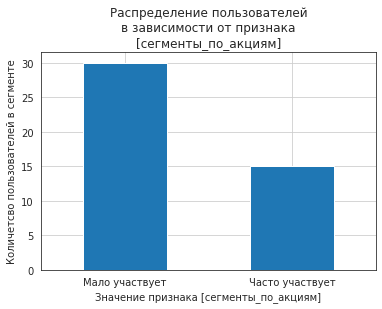

In [192]:
true_group5.pivot_table(index=['сегменты_по_акциям'], values=['id'], aggfunc='count').plot(kind='bar', rot=0, grid=True, legend=False)
plt.title('Распределение пользователей\nв зависимости от признака\n[{}]'.format('сегменты_по_акциям'))
plt.xlabel('Значение признака [{}]'.format('сегменты_по_акциям'))
plt.ylabel('Количетсво пользователей в сегменте')
plt.show()

Задача персонализированных предложений - минимизировать долю акционных покупок. Для этого следует заинтересовать пользователя другими товарами, повысив активность его взаимодействия с сайтом для выбора других товаров. Предлагать новые акции (снижение цены на товары) - нецелесообрано. Предлагается изменить политику стоимости доставки - временно сделать доставку бесплатной для рассматриваемых пользователей, затем в зависимости от результатов либо оставить навсегда бесплатную доставку, либо отменить. 

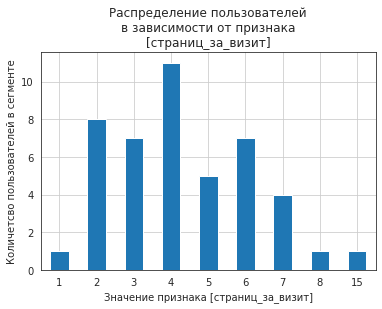

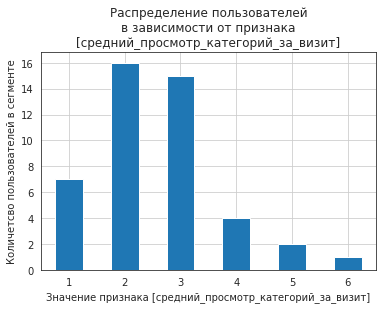

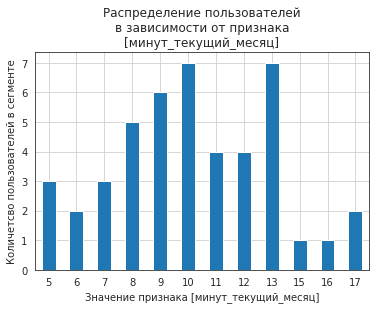

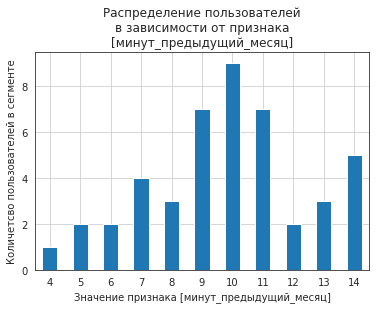

In [193]:
for item in ['страниц_за_визит', 'средний_просмотр_категорий_за_визит', 'минут_текущий_месяц', 'минут_предыдущий_месяц']:
    true_group5.pivot_table(index=item, values='id', aggfunc='count').plot(kind='bar', rot=0, grid=True, legend=False)
    plt.title('Распределение пользователей\nв зависимости от признака\n[{}]'.format(item))
    plt.xlabel('Значение признака [{}]'.format(item))
    plt.ylabel('Количетсво пользователей в сегменте')
plt.show()

Задача персонализированных предложений - максимизировать активность взаимодействия пользователя с сайтом для выбора других товаров. Предлагается в персонализированном предложении привлечь внимание пользователя к смежным категориям товаров, относительно самой популярной. Привлечение внимания возможно наличием небольших случайных подарков на страницах смежных категорий.

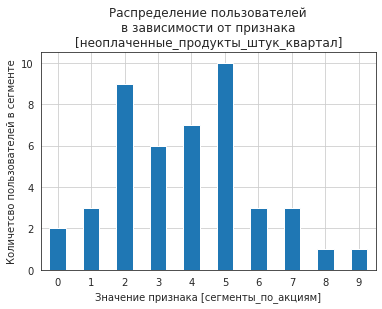

In [194]:
true_group5.pivot_table(index='неоплаченные_продукты_штук_квартал', values='id', aggfunc='count').plot(kind='bar', rot=0, grid=True, legend=False)
plt.title('Распределение пользователей\nв зависимости от признака\n[{}]'.format('неоплаченные_продукты_штук_квартал'))
plt.xlabel('Значение признака [{}]'.format('сегменты_по_акциям'))
plt.ylabel('Количетсво пользователей в сегменте')
plt.show()

Задача персонализированных предложений - минимизировать количество неоплаченных продуктов в корзине. Предлагается в персонализированном предложении временно отменить платную доставку. Также можно привлечь внимание пользователя к оплате корзины (заказу товаров) путем психологического воздействия (сравнение с рынком, уговоры, мольба, угрозы и т.д.) в предложении в зависимости от категории продуктов в корзине. За решением вопроса правильного воздействия просим обращаться к маркетологам. 

### Вывод по разделу "Сегментация покупателей"

В рамках работы была выполнена сегментация пользователей по нескольким группам и изучена группа клиентов группа клиентов с высокой вероятностью снижения покупательской активности (на основании реузльтатов моделирования) и наиболее высокой прибыльностью (на основании дополнительных данных финансового подразделения).

В соответствии с результатами моделирования наиболее важными признаками, влияющими на изменение покупательской активности являются:
- доля акционных покупок: чем больше, тем вероятнее снижение активности;
- активность взаимодействия с сайтом (количество просмотренных страниц за визит, средний просмотр категорий за визит, длительность времени, проведенного на сайте за период): чем больше, тем менее вероятно снижение активности;
- количество неоплаченных продуктов: чем больше, тем вероятнее снижение активности.

Задача персонализированных предложений - уменьшить или увеличить вышеуказанные признаки для изменения вероятности снижения активности. Для этого предлагается:
- минимизировать долю акционных покупок. Для этого следует заинтересовать пользователя другими товарами, повысив активность его взаимодействия с сайтом для выбора других товаров. Предлагать новые акции (снижение цены на товары) - нецелесообрано. Предлагается изменить политику стоимости доставки - временно сделать доставку бесплатной для рассматриваемых пользователей, затем в зависимости от результатов либо оставить навсегда бесплатную доставку, либо отменить. 
- максимизировать активность взаимодействия пользователя с сайтом для выбора других товаров. Предлагается в персонализированном предложении привлечь внимание пользователя к смежным категориям товаров, относительно самой популярной. Привлечение внимания возможно наличием небольших случайных подарков на страницах смежных категорий.
- минимизировать количество неоплаченных продуктов в корзине. Предлагается в персонализированном предложении временно отменить платную доставку. Также можно привлечь внимание пользователя к оплате корзины (заказу товаров) путем психологического воздействия (сравнение с рынком, уговоры, мольба, угрозы и т.д.) в предложении в зависимости от категории продуктов в корзине. За решением вопроса правильного воздействия просим обращаться к маркетологам.

## Итоговый вывод

В соответствии с планом работы были достигнуты следующие результаты.

**А. Изучение входных данных**

Для проведения исследования была получена выборка из 1300 записей о пользователях интернет-магазина с указанием категории их покупательской активности. Можно сделать _предварительный_ вывод, что предоставленных данных достаточно для достижения цели исследования. Были выявлены некоторые проблемы с входными данными, требующие предобработки: проблемы с представлением дата-сетов, проблемы с типами данных, возможные дубликаты.

**Б. Предобработка данных**

В ходе предобработки данных не были обнаружены пропущенные значения.

Не были обнаружены полные, но были обнаружены неявные дубликаты в столбце тип_сервиса (дубликаты значений "стандарт" и "стандартт"). Дубликаты устранены. Кроме того, исправлена одна ошибка в значениях столбца "Период" таблицы "market_time.csv".

Изменены типы данных в соответствии с их содержанием в столбцах с численными показателями. В частности, столбеу "Прибыль" таблицы "money.csv". Сведения в указанном столбце были представлены в виде строк с символами, которые не могут быть использованы при анализе и разработке моделей машинного обучения. Причиной появления данных с некорректными типами данных является принцип сбора и сохранения данных со стороны заказчика (использование запятой вместо точки в представлении дробных чисел). Изменен тип данных в соответствии с их содержанием в столбце с бинарным признаком Разрешить сообщать таблицы "market_file.csv".

**В. Результаты исследовательского анализа**

В результате проведения исследовательского анализа были выявлены ряд факторов, влияющих на достижение цели исследования.

В результате исследования категориальных признаков дата-сетов не выявлено значимого дисбаланса классов. При этом, в рамках машинного обучения при делении выборок на тренировочную и тестовую принято решение использовать стратификацию по целевому признаку (соотношение значений 2 к 3).

Целевой признак - категориальный. Разрабатываемая модель машинного обучения должна прогнозировать снизится ли покупательская активность пользователя (подробности выбора в промежуточном выводе по  по разделу "Исследовательский анализ данных"), а именно: *класс 0 - "Прежний уровень" - для интернет-магазина хорошо; класс 1 - "Снизилась" - для интернет-магазина плохо.**

При разработке машинного обучения будем особое внимание обращать на ошибку первого рода - ложно-отрицательную (FN). Предлагается оценивать метрики _recall_ и _roc_auc_ (подробности выбора в промежуточном выводе по разделу "Исследовательский анализ данных").

*В результате исследования количественных параметров дата-сетов выявлены как выбросы, не похожие на аномалии, так и аномальные значения. Аномальные значения удалены, другие выбросы решено оставить.*

После очистки данных распределения признаков показывают адекватную картину. Имеются основания утверждать, что распределения непрерывных случайных велинин - не нормальны. Распределения дискретных случайных величин имеют признаки распределения Пуассона.

В результате анализа выявлено, что для каждого из трех периодов распределение выручки различно. Столбец таблицы с исходными данными был разделен на три столбца "выручка_препредыдущий_месяц", "выручка_предыдущий_месяц" и "выручка_текущий_месяц". Также для каждого из двух периодов распределение времени, проведенного на сайте, различно. Столбец таблицы с исходными данными был разделен на три столбца "минут_предыдущий_месяц" и "минут_текущий_месяц". Проанализированы и визуализированы характеристики распределений удельных показателей.

_В результате работы со таблицей "market_money.csv" были отбераны клиенты с покупательской активностью не менее трёх месяцев, то есть такие, которые что-либо покупали в этот период._

**Г. Дополнение, объединение и разделение данных**

Для дальнейшего анализа выполнены следующие работы:
- объединены таблицы market_file.csv, market_money.csv, market_time.csv. 
- учтено, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделан отдельный столбец для каждого периода.

**Д. Результаты корреляционного анализа**

В результате проведения корреляционного анализа выявлены следующие факторы, влияющие на результат работы.
1. Сильной линейной связи (коэффициент корреляции от 0.9 и выше) между входными признаками (мультиколлениарности) не обнаружено.
2. Линейной связи между входными и целевым признаком не обнаружено. Сильного однозначного влияния входных признаков на целевой признак не выявлено

**Е. Разработка моделей машинного обучения**

В результате поиска лучшей модели достигнуты следующие результаты:

1. Сформирован pipeline для поиска лучшей модели с использованием подбора гиперпараментров по сетке для четырех моделей KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC().
2. В сетку гиперпараментров для каждой модели подобраны несколько гиперпараметров, данные маштабированы как минимум двумя методами, отдельно обработаны категориальные и количественные признаки.
3. На основании выбранных метрик (TPR и ROC-AUC) выбран подбор гиперпараментров с мультискорингом.
4. Метрика TPR лучшей модели на тренировочной выборке составила 0.769. Лучшей признана модель SVC(). При этом, метрика ROC-AUC ниже максимальной. Если важнее правильно находить пользователей со сниженной активностью — тогда выбор за моделью с лучшей TPR. Если важнее качественно классифицировать данные — стоит выбрать модель с высокой ROC-AUC.
5. Метрика TPR (RECALL) лучшей модели на тестовой выборке: 0.829, метрика ROC-AUC лучшей модели на тестовой выборке: 0.915.
    

**Ж. Анализ важности признаков**

В соответствии с визуализацией влияния признаков на классификацию можно сделать следующие выводы:
- самый важный признак - доля акционных покупок: чем больше, тем вероятнее снижение активности;
- активность взаимодействия с сайтом (количество просмотренных страниц за визит, средний просмотр категорий за визит, длительность времени, проведенного на сайте за период): чем больше, тем менее вероятно снижение активности;
- количество неоплаченных продуктов: чем больше, тем вероятнее снижение активности.
- выручка текущий месяц: чем меньше, тем вероятнее снижение активности.
- популярная категория "Мелкая бытовая техника": чем более популярная категория, тем вероятнее снижение активности.

Маловажными признаками являются:
- количество маркетинговых коммуникаций в текущем месяце - в связи с тем, что мы обучали модель на результатах активности за текущий месяц, вполне логично, что данный признак не может влиять на целевой признак. Для предсказаний на будущий период указанный признак окажется ретроспективным.
- разрешение на дополнительные предложения - на активность не влияет. Повлияет только на рассылку предложений - увеличить активность пользователей, которые запретили дополнительные предложения, с помошью этих предложений не удастся.
- тип сервиса - на активность влияет очень слабо. Снижений активности наблюдается для пользователей с различным сервисом.

Популярные категории, длительноть регистрации и количество ошибок на сайте влияют слабо.

Из выводов следуют несколько гипотез:
Если снижается активность постоянных клиентов при большом количестве акционных покупок надо проработать условия для каких-то дополнительных льгот, чтобы их удерживать.
Надо повышать длительность взаимодействия пользователей с сайтом, например, увеличить его юзабилити, добавить небольшие подарки на случайных страницах.
Необходимо сколнять пользователей к оплате добавленных товаров в корзину, например, бесплатной доставкой, персональными предложениями, влияющими на принятие решения пользователя об оплате товаров.

**З. Сегментация покупателей**

В рамках работы была выполнена сегментация пользователей по нескольким группам и изучена группа клиентов группа клиентов с высокой вероятностью снижения покупательской активности (на основании реузльтатов моделирования) и наиболее высокой прибыльностью (на основании дополнительных данных финансового подразделения).

В соответствии с результатами моделирования наиболее важными признаками, влияющими на изменение покупательской активности являются:
- доля акционных покупок: чем больше, тем вероятнее снижение активности;
- активность взаимодействия с сайтом (количество просмотренных страниц за визит, средний просмотр категорий за визит, длительность времени, проведенного на сайте за период): чем больше, тем менее вероятно снижение активности;
- количество неоплаченных продуктов: чем больше, тем вероятнее снижение активности.

Задача персонализированных предложений - уменьшить или увеличить вышеуказанные признаки для изменения вероятности снижения активности. Для этого предлагается:
- минимизировать долю акционных покупок. Для этого следует заинтересовать пользователя другими товарами, повысив активность его взаимодействия с сайтом для выбора других товаров. Предлагать новые акции (снижение цены на товары) - нецелесообрано. Предлагается изменить политику стоимости доставки - временно сделать доставку бесплатной для рассматриваемых пользователей, затем в зависимости от результатов либо оставить навсегда бесплатную доставку, либо отменить. 
- максимизировать активность взаимодействия пользователя с сайтом для выбора других товаров. Предлагается в персонализированном предложении привлечь внимание пользователя к смежным категориям товаров, относительно самой популярной. Привлечение внимания возможно наличием небольших случайных подарков на страницах смежных категорий.
- минимизировать количество неоплаченных продуктов в корзине. Предлагается в персонализированном предложении временно отменить платную доставку. Также можно привлечь внимание пользователя к оплате корзины (заказу товаров) путем психологического воздействия (сравнение с рынком, уговоры, мольба, угрозы и т.д.) в предложении в зависимости от категории продуктов в корзине. За решением вопроса правильного воздействия просим обращаться к маркетологам.

**И. Достижение цели работы**

Таким образом, в результате работы:
- разработана и интерпретирована модель машинного обучения с лучшими параметрами прогнозирования снижения активности пользователей.
- определены наиболее важные и неважные признаки снижения активности пользователей;
- сформулированы предложения по повышению покупательской активности пользователей.

**Цель исследования достинута - на основании исходных данных с использованием моделей машинного обучения выполнен прогноз покупательской активности постоянных клиентов интернет-магазина и предложены способы увеличения их покупательской активности.**